<a href="https://www.kaggle.com/code/mishki/time-series-demand-forecast-arma-prophet?scriptVersionId=92059417" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Quick intro**

This notebook is about demand prediction on a simple time series dataset. I think it's a good precursor to a crypto or stocks prediction problem later on.

I have anoher notebook / tutorial that takes one through the <a href="https://www.kaggle.com/mishki/tutorial-time-series-exploration-crypto-price">**basics of working with time series**</a>, so here I skip the basic theory.

What this notebook is:  
- a good starting point for working with classic time series prediction models
- a cookbook we can use for exploration of what type of models may fit when starting to work with a new dataset

What this notebook is not:
- it's not meant for advanced practitioners of time series forecast - unless you want to revisit some concepts.  

### Contents

[1. Quick overview](#1.-Quick-overview)  
[2. Dataset exploration](#2.-Dataset-exploration)  
[3. Feature engineering](#3.-Feature-engineering)  
[4. Model building and evaluation](#4.-Model-building-and-evaluation)    
    [4.1 Smoothing-methods](#4.1-Smoothing-methods)  
    [4.2 ARMA & versions](#4.2-ARMA-&-versions)  
    [4.2.1 ARMA](#4.2.1-ARMA)  
    [4.2.2 SARIMA](#4.2.2-SARIMA)  
    [4.3 Prophet & Neural Prophet](#4.3-Prophet-&-Neural-Prophet)    
    [4.3.1 Prophet](#4.3.1-Prophet)  
    [4.3.2 Neural Prophet](#4.3.2-Neural-Prophet)  
    

In [1]:
!pip install neuralprophet[live]

     |████████████████████████████████| 74 kB 320 kB/s            


In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 287 kB/s            


In [3]:
import pandas as pd
import numpy as np
import os 
import time
import csv
import itertools

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error

# Prophet
from fbprophet import Prophet
from fbprophet.plot import plot_yearly, add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation, performance_metrics

# Neural Prophet
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed # for reproducibility 
import neuralprophet
import math
import torch
torch.pi = math.pi # this is a temporary workaround for a neural prophet bug

# feature selection
from sklearn.svm import SVC
from yellowbrick.model_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

#arima
from pmdarima.arima import auto_arima
from pmdarima import pipeline
from pmdarima import preprocessing as ppc
from pmdarima import arima

In [4]:
img_w = 12
img_h = 6
        
# by default, figure size is very small; we set a larger value as default one
plt.rcParams.update({'figure.figsize': (img_w, img_h)})    

# 1. Quick overview

This dataset was made available on Kaggle as part of the <a href='https://www.kaggle.com/c/demand-forecasting-kernels-only/overview'>Store Item Demand Forecasting Challenge</a>. 

You are given 5 years of store-item sales data for 50 different items at 10 different stores and asked to predict the following 3 months of sales.

# 2. Dataset exploration

In [5]:
data_folder = "../input/demand-forecasting-kernels-only/"
!ls $data_folder

sample_submission.csv  test.csv  train.csv


In [6]:
train_df = pd.read_csv(os.path.join(data_folder, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_folder, 'test.csv'))

What is the structure of the data ? What fields do we have in the two files ?

**Training set exploration**

In [7]:
train_df.head(5)

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

`date` - the data seems to have a daily resolution  
`store` - unique identifier of the store from which the data comes from; we know from the competition description that there are 10 stores  
`item` - unique identified of an item; we know there are 50 different items (same items offered in all 10 stores)    
`sales` - absolute number of items sold in the time resolution (the respective day)  

In [8]:
train_df.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

- there are 913k entries in the training set  
- store id goes from 1 to 10  
- item id goes from 1 to 50  
- sales ranges from 0 to 231 (therefore, we draw the conclusion that 'no sale' for the day is reported as 0 not as nan/missing value)

**Check for missing values**  

In [9]:
train_df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

The next question that comes to mind if whether we can have a whole day of data missing for any (store, item) combination.  

An easy way to test this is to count the number of entries for each (store, item) combination.

In [10]:
train_df.groupby(['store', 'item']).count().sales.value_counts()

1826    500
Name: sales, dtype: int64

The results above tells us that:  
- we have 500 different (store, item) pairs (which is correct, given our 10 stores x 50 items problem description)  
- each pair has 1826 entries. So, either each of them misses the same amount of data (highly unlikely) or they all have no missing entries (no missing day). I assume the latter, due to its higher probability. 

In [11]:
train_df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

As expected (due to reading from CSV with default settings), the date is a string. Let's make it a datetime. 

In [12]:
train_df['date'] = pd.to_datetime(train_df['date'])

Let's make the `date` column the index of this dataframe. Seems to make more sense and will facilitate some operations (plotting for example or finding gaps in consecutive rows).

In [13]:
train_df.set_index('date', inplace = True)

Training data time interval  

We have 5 full years of data, indeed: from **Jan 1st 2013** to **Dec 31st 2017**. 

In [14]:
train_df.iloc[0], train_df.iloc[-1]

(store     1
 item      1
 sales    13
 Name: 2013-01-01 00:00:00, dtype: int64,
 store    10
 item     50
 sales    82
 Name: 2017-12-31 00:00:00, dtype: int64)

**Test set exploration**

In [15]:
test_df.head(5)

id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1

We have the `store` and `item` variables, as expected.  
`id` is probably some unique identifier of each entry in the test_df table (for who knows what reasons) - we check this assumption below.

In [16]:
test_df.id.nunique(), len(test_df)

(45000, 45000)

The structure of the test file is most likely just a convenience. We should add a `sales` column containing our prediction before submitting to Kaggle for checking against their actual test data.

**Dilemma**  

We saw earlier that there are 500 (store, item) pairs for which we have data and for which we need to make a predictions.  

How to approach this problem ? The most obvious solution it to fit a model to each (store, item). That would be 500 models 😱  

To make life easier, I'll start with a single (store, item) pair and find the best model for it. And I'll think about the other 499 later.  

All analysis from now on will focus on data from a single pair.

In [17]:
pair_df = train_df[(train_df.store==1) & (train_df.item==1)].copy(deep=True) 

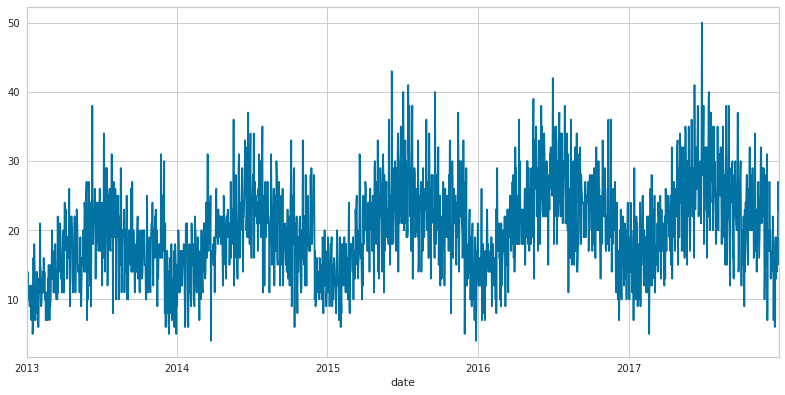

In [18]:
pair_df.sales.plot(); 

# 3. Feature engineering  

In the plot above I can see a seasonal pattern. I will engineer then some extra features that seem commonsense for a dataset with a seasonal pattern.

In [19]:
train_df = pd.read_csv(os.path.join(data_folder, 'train.csv'))

train_df['date'] = pd.to_datetime(train_df['date'])

train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.dayofyear
train_df['weekday'] = train_df['date'].dt.weekday

train_df.set_index('date', inplace = True)

pair_df = train_df[(train_df.store==1) & (train_df.item==1)].copy(deep=True) 

Examine the daily pattern  

In the plot below, days go from 0 (Monday) to 6 (Sunday).  
On average, sales volumes increase from Monday and reach their peak on Sunday.  
Some week days also show ouliers (maybe holidays ?)

In [20]:
pair_df.day.nunique()

366

<AxesSubplot:xlabel='weekday', ylabel='sales'>

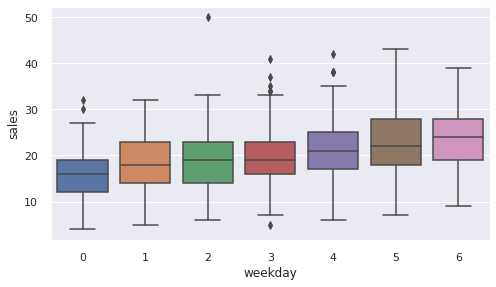

In [21]:
sns.set(rc={"figure.figsize":(7, 4)})

sns.boxplot(x="weekday", y="sales", data=pair_df)

There is also an yearly pattern, with summer months being the most prolific and winter months the least.

<AxesSubplot:xlabel='month', ylabel='sales'>

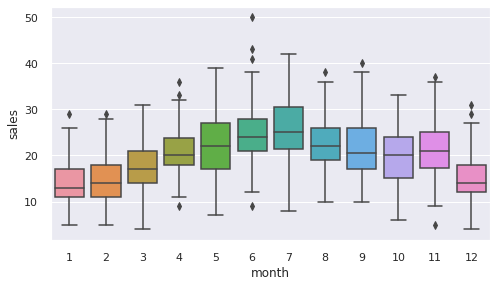

In [22]:
sns.boxplot(x="month", y="sales", data=pair_df)

In [23]:
# restore figure size to larger dimension
sns.set(rc={"figure.figsize":(img_w, img_h)})

**Train-test split**

In [24]:
print(f'Cutoff point for a 70-30 train-test split: {0.3 * len(pair_df)}')

print(pair_df.iloc[-547])

cutoff_date = '2016-07-03'

X_train, X_eval = pair_df.loc[pair_df.index <= cutoff_date].sales, pair_df.loc[pair_df.index > cutoff_date].sales

print(X_train.shape), print(X_eval.shape)

Cutoff point for a 70-30 train-test split: 547.8
store         1
item          1
sales        35
year       2016
month         7
day         185
weekday       6
Name: 2016-07-03 00:00:00, dtype: int64
(1280,)
(546,)


(None, None)

# 4. Model building and evaluation

Remember the structural decomposition of time series data:  
`Xt = Tt + St + Ct + Err`   
Xt = the value at time t  
Tt = the trend; a long term general drection  
St = seasonal component; something that repeats at known intervals (i.e. annually, monthly, weekly patterns)  
Ct = cyclical component; a pattern that does not occurr at predictable time points (i.e. a bull market)  
Err = something extra, ideally random, that cannot be modeled (we can call if error term)    

There is also one extra component not mentioned above: the level (overall average value).  

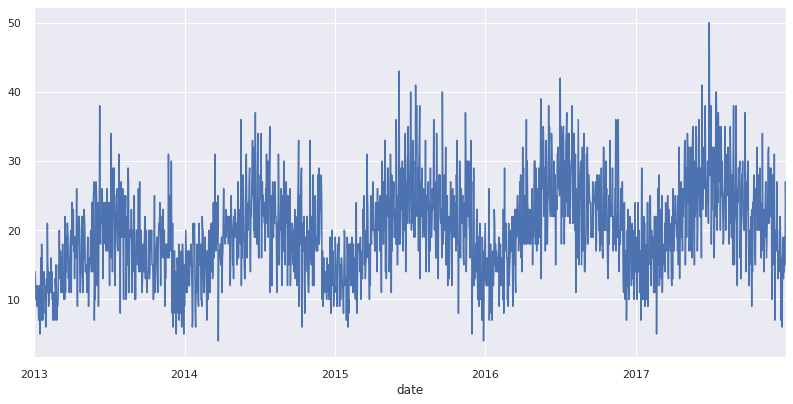

In [25]:
pair_df.sales.plot(); 

There is:  
- an obvious non zero level in the plot above  
- no discernable trend (not a very clear upward going or downward going movement on the long term)  
- a recurrent yearly pattern (seasonality)  

Let's do a seasonal decomposition to see it more clearly.

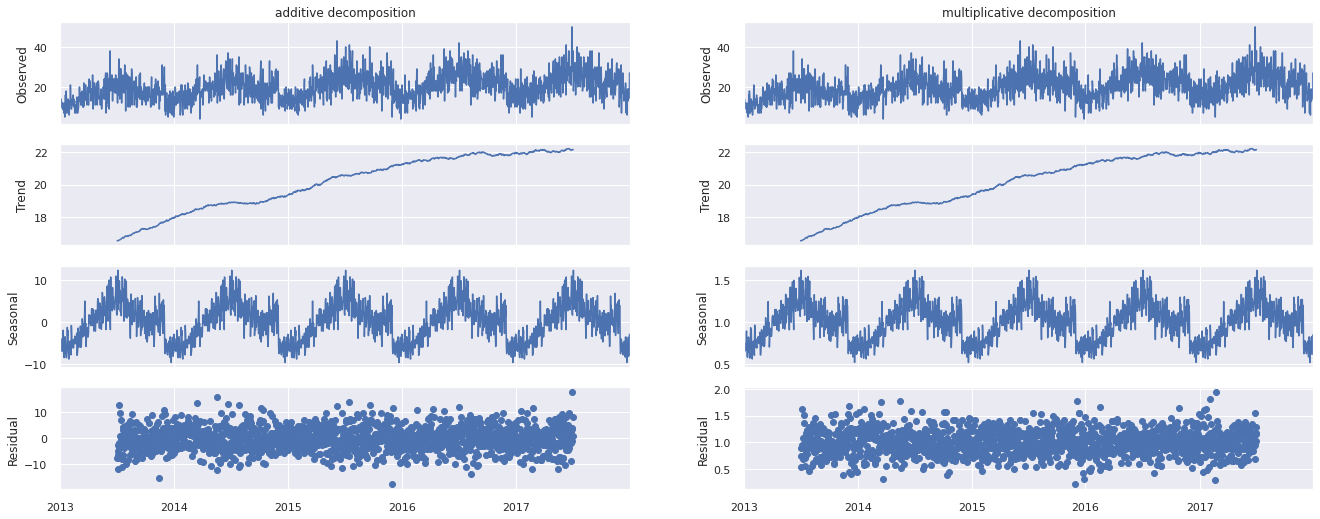

In [26]:
# perform seasonal decomposition
# we have daily data and from the plot above we see that one season lasts approx 1 year ~ 365 days 

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(20, 8))

for i,model in enumerate(['additive', 'multiplicative']):
    
    decomposition = sm.tsa.seasonal_decompose(pair_df.sales,period = 365, model=model) 
    decomposition.observed.plot(ax=axes[0,i], legend=False)
    
    axes[0,i].set_title(model + ' decomposition')
    
    axes[0,i].set_ylabel('Observed')
    decomposition.trend.plot(ax=axes[1,i], legend=False)
    axes[1,i].set_ylabel('Trend')
    decomposition.seasonal.plot(ax=axes[2,i], legend=False)
    axes[2,i].set_ylabel('Seasonal')
    #decomposition.resid.plot(ax=axes[3,i], legend=False)
    axes[3,i].scatter(np.array(decomposition.resid.index), decomposition.resid)
    axes[3,i].set_ylabel('Residual')
plt.show()


It looks like seasonal decomposition identified a trend too, in both cases.

The additive decomposition:  
- the seasonal component is quite obvious.   
- the residuals are larger than in the case of multiplicative decomp.

The multiplicative decomposition:  
- the seasonal component is small
- the residuals are small too

We proceed with the classic ADF test for stationarity to confirm what looks pretty obvious.

In [27]:
result = adfuller(pair_df.sales)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.157671
p-value: 0.022569
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



The augmented Dickey-Fuller test: the null hypothesis is that the series is non-stationary. If we get a small enough p, we reject the null hypothesis and conclude tha the series is stationary. 

The results above suggests that we reject the Null hypothesis and assume the series is stationary. This is unexpected.  

When a time series is stationary, it can be easier to model. Some statistical modeling methods require the time series to be stationary to be effective. According to the ADF result, we need not worry about this in this case. But the seasonal decomposition and the basic plot I did in the beginning show clear signs of nonstationarity, so I will not trust ADF in this case.

In [28]:
len(pair_df)

1826

In [29]:
result = adfuller(pair_df[:1700].sales)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.807998
p-value: 0.057140
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


It seems like the ADF test is significant only when we consider the whole amount of data, but if we reduce it and ignore the last 4-5 months of data, the test result indicated non-stationary data.   

From this and from the look of the seasonal decomposition plot, I think it's safer to assumer the data is non-stationary and adapt models to this assumption.

**Autocorrelation**

Autocorrelation and partial autocorrelation are explained very well in <a href='https://www.youtube.com/watch?v=DeORzP0go5I&ab_channel=ritvikmath'>this video</a> (how they are computed, what they mean and what we use them for).

\# Components sticking outside the blue area are statistically significant  
\# The first component is the current time point; the second component is a measure of the dependency between the current time point and one point back in time; and so on...  

According to the acf plot, a datapoint depends on the last 50 days of data and from than point on mostly on the same day of the week before.

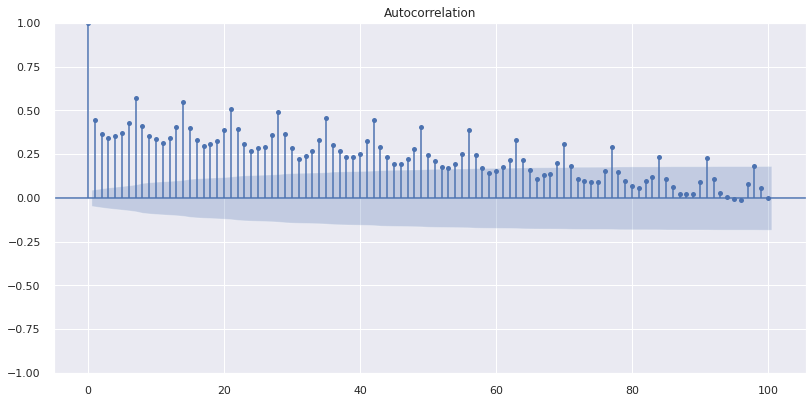

In [30]:
plot_acf(pair_df.sales, lags = 100)
print()

Partial autocorrelation looks at dependency between the current time point and past values while controlling for the time poins in between.  

When the dependencies between each day in between and its predecessor is taken into account, the current data point depends heavily on the previous 7 days and from then on, only on the same day the week before.

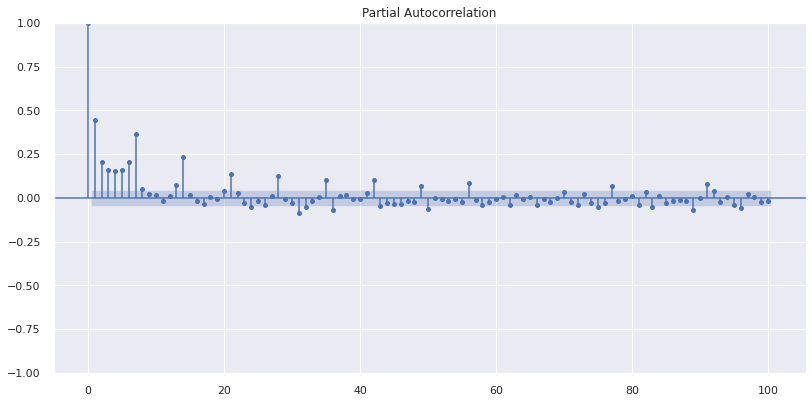

In [31]:
plot_pacf(pair_df.sales, lags = 100, method='ywm')
print()

# 4.1 Smoothing methods

Smoothing methods seem to be the oldest approach to time series modeling. As per testimonials of seasoned Time Series Data Scientists, some of them still give decent results for some datasets. So I'll take a look at a few of them too.

These are variations around the idea that a future observation can be modeled as a weighted average of past observations, with the weights decaying exponentially as the observations get older.   

According to <a href='https://otexts.com/fpp3/'>Forecasting: Principles and Practice (3rd ed)</a>, by Rob J Hyndman and George Athanasopoulos, here is a classification of popular exponential smoothing methods: 
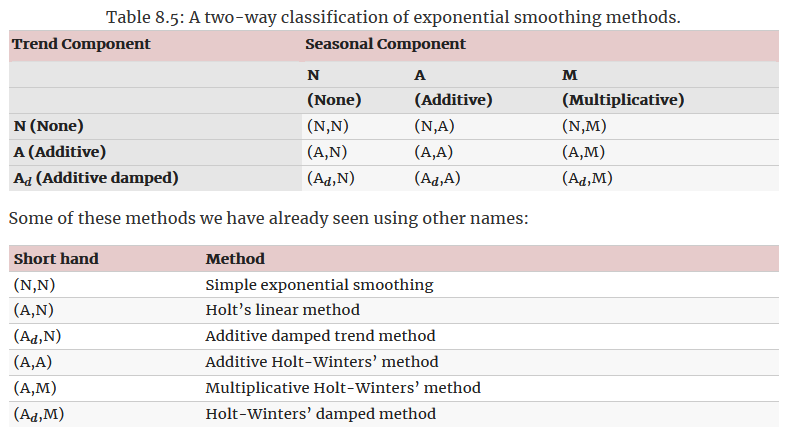

I found <a href='https://otexts.com/fpp3/expsmooth.html'>this</a> to be a good resource for learning about exponential smoothing.

I will try 3 of those on this dataset (because I'm rather sure they will not be enough, so no need to try them all, I assume):  

    (N,N) - aka the simple exponential smoothing
    (A,N) - aka double exponential smoothing or Holt's linear trend method
    (A,A) - aka triple exponential smoothing or additive Holt-Winters' method


**Simple exponential smoothing**

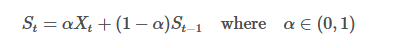  

The out ouf sample predictions follow this formula:  

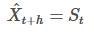
that is, future values are predicted as the last known computation for which we had data (so it's gonna be a flat line).

- also known as Brown method  
- it has one parameter: alpha; I will try a few values and see the effect  
- this method basically predicts the level component (from the structural decomposition seen earlier).

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



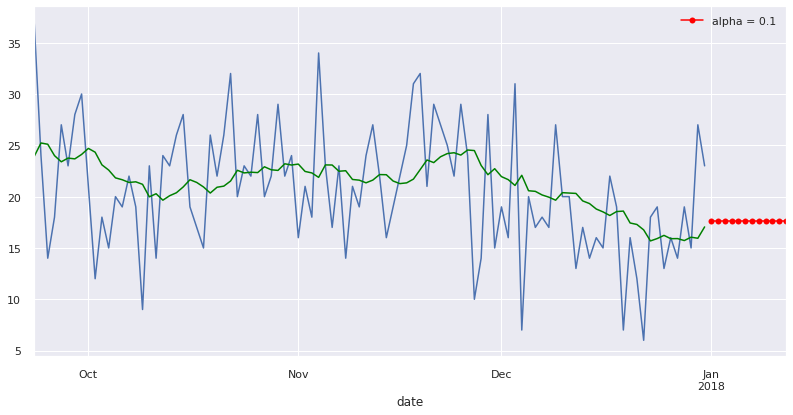

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



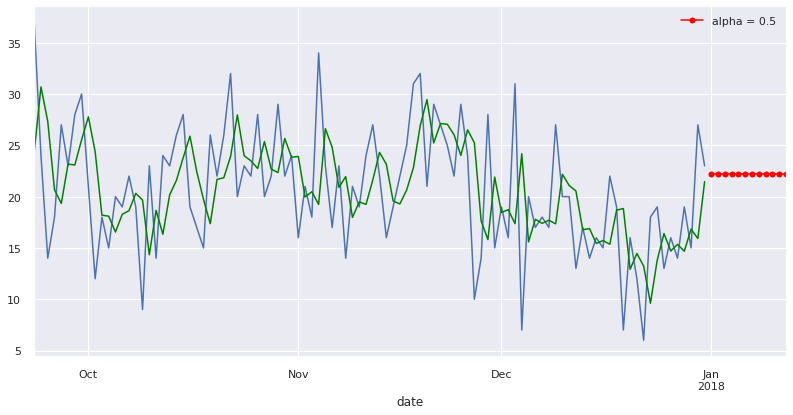

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



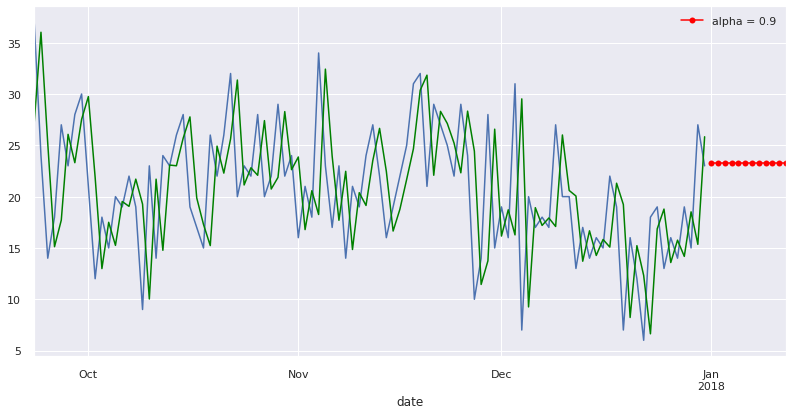

In [32]:
for alpha_sm in [0.1, 0.5, 0.9]:
    df = pair_df.sales
    
    fit1 = SimpleExpSmoothing(df).fit(smoothing_level = alpha_sm  ,optimized=False)
    fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))
    
    df[-100:].plot.line()
    fcast1.plot(marker='o', color='red', legend=True)
    fit1.fittedvalues[-100:].plot(  color='green')
    
    plt.show()

Observations:  
- the lower the alpha, the more atenuated the prediction (as an average of the previous values, it cuts more into the volatility), the higher the alpha the closer the prediction is to the real volatily of previous data points  
- the out of sample predictions (the last 12 predictions) are flat line.

**Double exponential smoothing**  

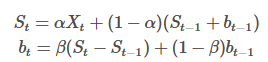

S1=X1, b1=X1−X0 and α,β∈(0,1)

- this method basically predicts the level and the trend from the structural decomposition seen earlier  
- this model has 2 parameters: alpha and beta  

The out of sample forecast is:  
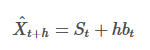

Below I compare simple and double exponential smoothing.  
I use the alpha = 0.5 value, which led to moderate attenuation and the same dataset as before. I will only plot the last 100 data points (for visibility reasons).

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



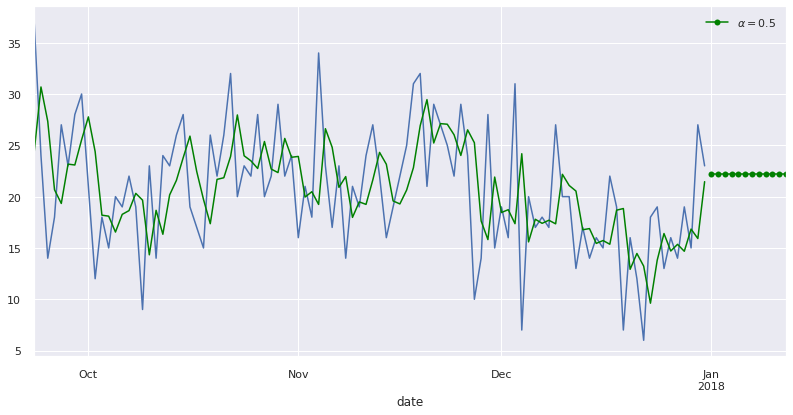

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  del sys.path[0]



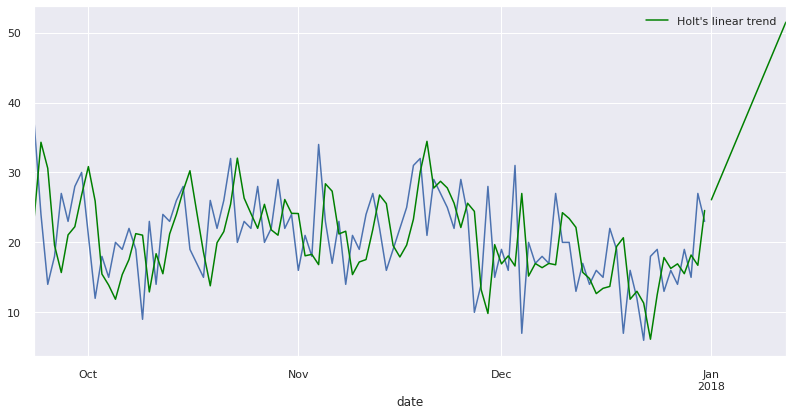

In [33]:
alpha = 0.5

fit1 = SimpleExpSmoothing(df).fit(smoothing_level=alpha, optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.5$')  # forecasting only 12 days (since it's a flat prediction anyway)
fcast1.plot(marker='o', color='green', legend=True) # plot forecast

df[-100:].plot.line()
fit1.fittedvalues[-100:].plot(  color='green')

plt.show()


fit1 = Holt(df).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")  # forecasting only 12 days (enough to get an idea of what predictions look like)
fcast1.plot(color='green', legend=True)

df[-100:].plot.line()
fit1.fittedvalues[-100:].plot(color='green')


plt.show()

Observations:
- in sample predictions look like a shadow of the past data (a lagged version) for both methods, but more attentuated in the first method
- out of sample predictions stop being a flat line for the double exponential, but exaggerate the short term trend

**Triple exponential smoothing**  

It's defined as:  
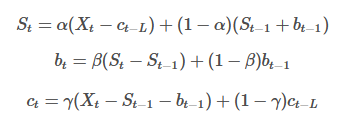

And out of sample predictions will be:  
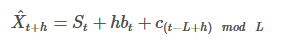

I will use the same data as before and:  
- predict the following 1 year worth of data this time (so we can see a whole season of predicted data, because now it makes sense to look at it since it's not going to be flat or a straight line as earlier)  
- plot approximately 2 years of historical data (to visually compare predictions against)  

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



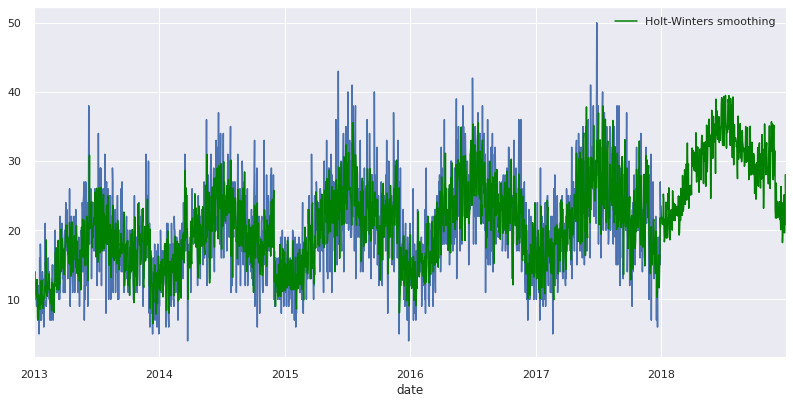

In [34]:
alpha = 0.5
seasonal_periods = 365

fit1 = ExponentialSmoothing(df, seasonal_periods=seasonal_periods, trend='add', seasonal='add', use_boxcox=True)
fit1 = fit1.fit(smoothing_level=0.5)
fit1.forecast(365).rename("Holt-Winters smoothing").plot(color='green', legend=True)

df.plot.line()
fit1.fittedvalues.plot(color='green')

plt.show()

This method is clearly a candidate model for which to actually perform a train-test split and compute metrics.  

Remember from earlier seasonal decomposition plots (at the start of section 4), that it was not clear if additive or multiplicative decomposition is better. So I would try both and compare metrics.

**Model evaluation**

Use the same smoothing parameters and season length.  

Remember we have daily data, so one year season will be 365 data points long (at least 3 out of 4 years).

In [35]:
alpha = 0.5
seasonal_periods = 365

In [36]:
es3_model = ExponentialSmoothing(X_train, seasonal_periods=seasonal_periods, trend='add', seasonal='add', use_boxcox=True)

es3_model = es3_model.fit() # no alpha given; I will let the algorithm find the best alpha

prediction = es3_model.forecast(len(X_eval)).copy()

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



**Residuals**

Examine information contained in the model's residuals.  

Start with autocorrelation (ACF). If there is a significant lagged component, it means there is still information left in the residuals, which could be captured by an improved model.  

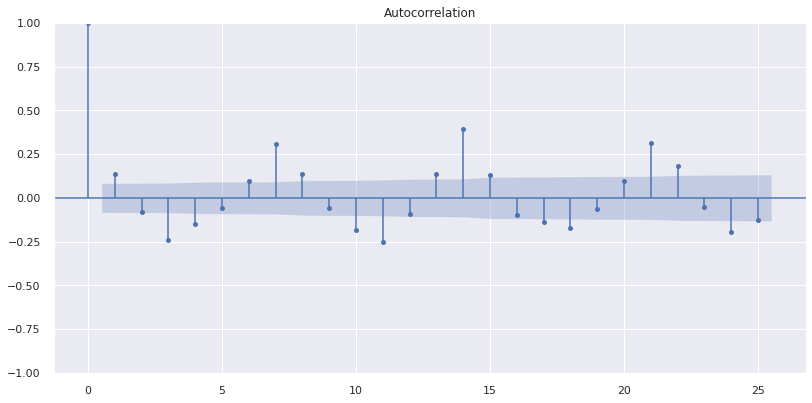

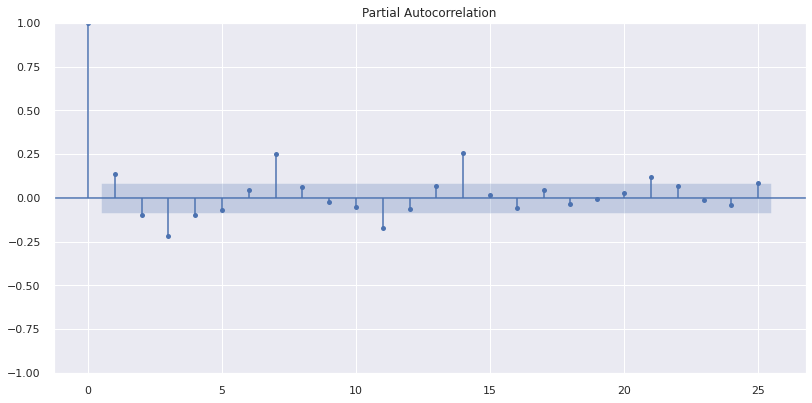

In [37]:
xresiduals = X_eval - prediction
plot_acf(xresiduals, lags = 25)
print();

plot_pacf(xresiduals, lags = 25, method='ywm')
print()

 Even when the mediation from intermediate time points is taken out of the relationship, there is a significant relationship between the current time point and the ones from 1 and 2 weeks before.  

Conclusion:  
- we saw in the seasonal decomposition an annual seasonality  
- we now see in the residuals of a triple exponential smoothing model a weekly seasonality which was not captured by this model and remained in the residuals.

**Metrics**

Formal model evaluation: let's check metrics.

In [38]:
y_true = X_eval.values

mae_add = mean_absolute_error(y_true, prediction)

print(f'MAE for triple exponential smoothing model: {mae_add:.3f}')

MAE for triple exponential smoothing model: 5.411


Save it for later, to compare it to Prophet and ARMA.

In [39]:
results_df = pd.DataFrame.from_dict({'method': ['additive'], 'mae': [mae_add]})
results_df.index = ['Triple exponential smoothing']

results_df

method       mae
Triple exponential smoothing  additive  5.411132

Visualize predictions versus real data (the held out evaluation set).

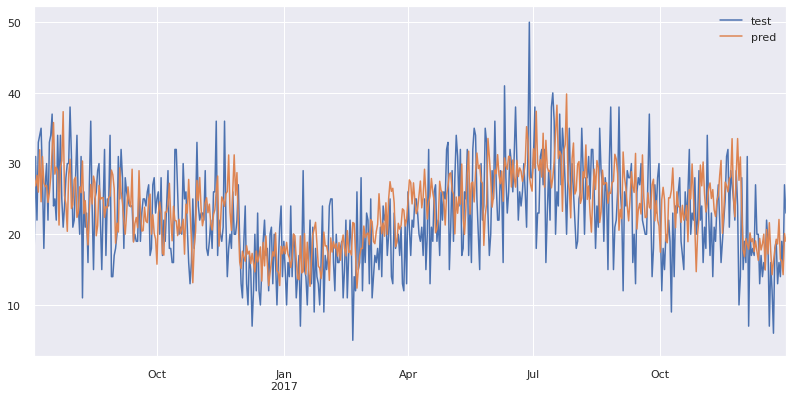

In [40]:
pd.DataFrame({'test':X_eval,'pred':prediction}).plot();plt.show()

# 4.2 ARMA & versions

In this section I will try:  
4.2.1 ARMA  
4.2.2 SARIMA  

ARMA assumes stationary data and, although ADF test ruled the whole dataset to be stationary, it did not look stationary. In order to use ARMA, I need to manuall direference the data (to remove the trend component) and to use a trick called FourierFeaturizer (to account for seasonality). 

SARIMA accepts non-stationary data (the 'I' comes from 'integated') and with a seasonal component (hence the 'S' in the name).  

# 4.2.1 ARMA

Needs a **stationary series** =>  
- need to get rid of the trend from the data
- need to account for seasonality

Revisit seasonal decomposition

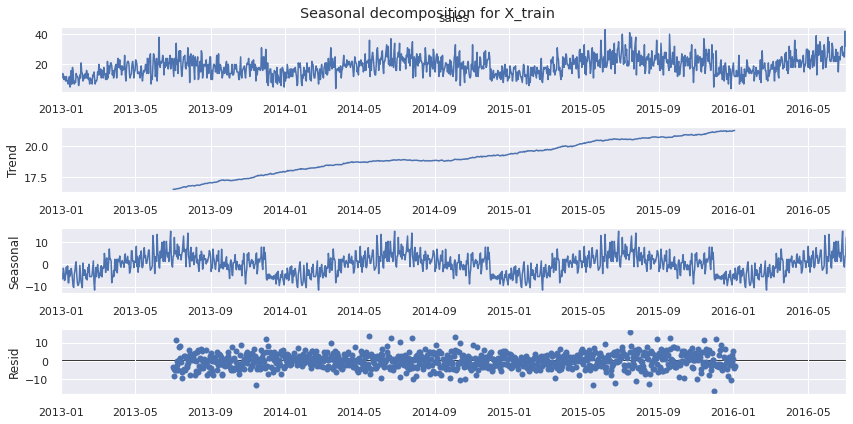

In [41]:
decomposition = sm.tsa.seasonal_decompose(X_train,period = 365, model = 'additive') 
fig = decomposition.plot()
fig.suptitle('Seasonal decomposition for X_train')

plt.show()

From the plot above, the trend seems linear. That means that if we take the first derivative of the series, we should obtain a "flat line", that is, a series without a trend.


**Differencing**  

<AxesSubplot:xlabel='date'>

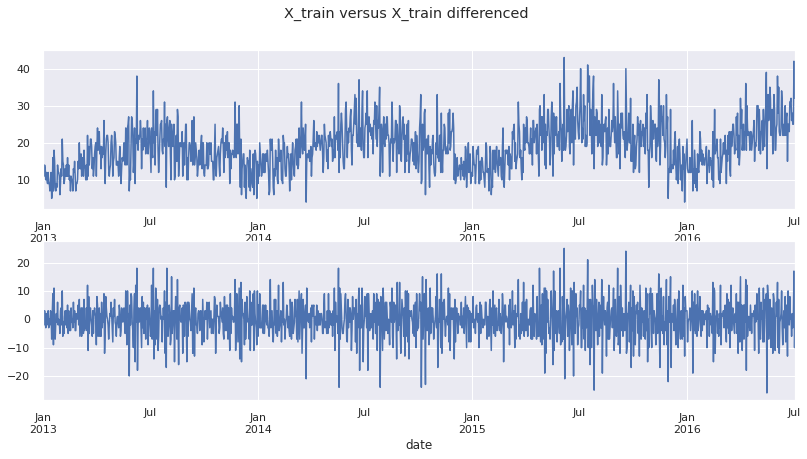

In [42]:
fig, axs = plt.subplots(2)
fig.suptitle('X_train versus X_train differenced')

X_train.plot(ax = axs[0])

X_train_diff = X_train.diff()
X_train_diff.plot(ax = axs[1])

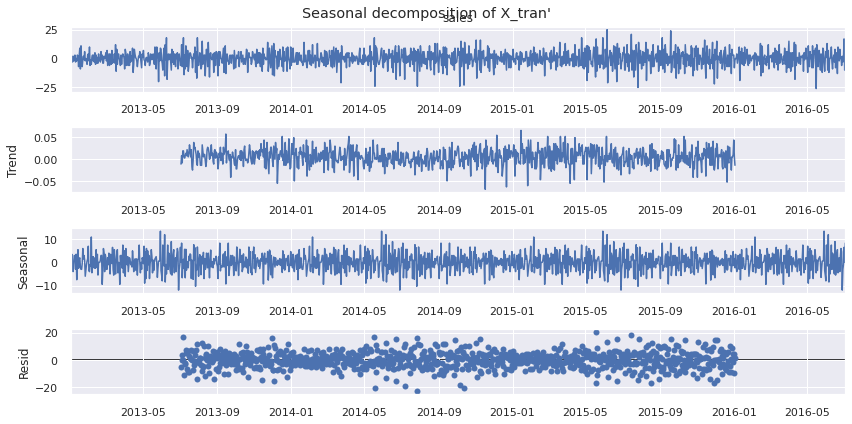

In [43]:
decomposition = sm.tsa.seasonal_decompose(X_train_diff.dropna(),period =365, model = 'additive') 

fig = decomposition.plot()
fig.suptitle('Seasonal decomposition of X_tran\'')

plt.show()

It looks like taking the first derivative leads to a dataset that seems stationary. I'll formally test this assumption.

In [44]:
result = adfuller(X_train_diff.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.680538
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


ADF confirms the stationarity assumption of the differentiated dataset.  

**Autocorrelation of the differenced series**

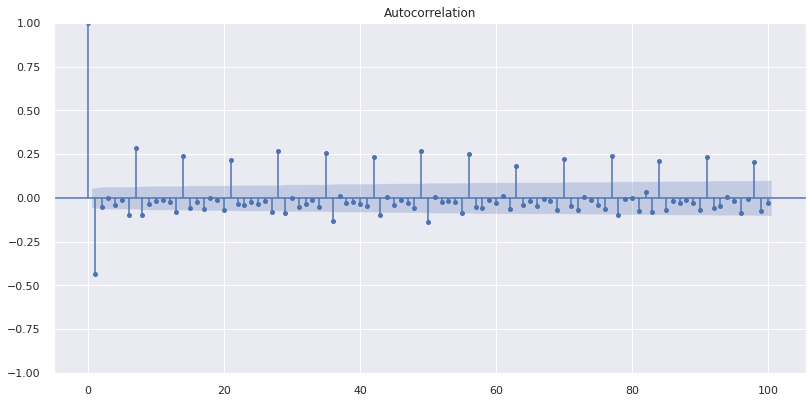

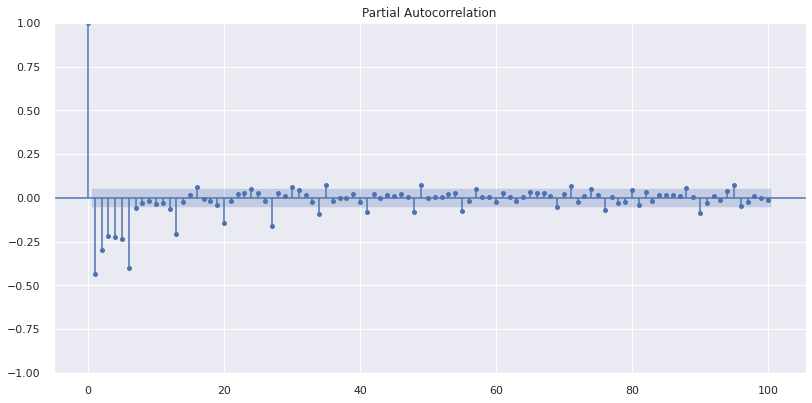

In [45]:
plot_acf(X_train_diff.dropna().values, lags = 100); print(); plot_pacf(X_train_diff.dropna().values, lags = 100, method='ywm'); print()

The value for `p` parameter for the ARMA model can be deduced from the pacf plot above: a lag of 6 seems the best fit.

**ARMA**

Use ARMA to model the differentiated data.

In [46]:
# construct a pipeline so I can use FourierFeaturizer
arma_model = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=365)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              start_p = 7, max_p = 7,
                              start_q = 7, max_q = 10,
                              d=0, # no differencing (already did that manually)
                              suppress_warnings=True))
])

arma_model.fit(X_train_diff.dropna())

Performing stepwise search to minimize aic
 ARIMA(7,0,7)(0,0,0)[0]             : AIC=7822.887, Time=242.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8975.971, Time=46.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8654.622, Time=37.84 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8094.114, Time=111.95 sec
 ARIMA(6,0,7)(0,0,0)[0]             : AIC=7819.240, Time=216.91 sec
 ARIMA(5,0,7)(0,0,0)[0]             : AIC=7976.839, Time=216.05 sec
 ARIMA(6,0,6)(0,0,0)[0]             : AIC=7950.435, Time=244.94 sec
 ARIMA(6,0,8)(0,0,0)[0]             : AIC=7825.797, Time=269.67 sec
 ARIMA(5,0,6)(0,0,0)[0]             : AIC=7931.817, Time=243.57 sec
 ARIMA(5,0,8)(0,0,0)[0]             : AIC=7924.168, Time=262.69 sec
 ARIMA(7,0,6)(0,0,0)[0]             : AIC=7924.224, Time=238.16 sec
 ARIMA(7,0,8)(0,0,0)[0]             : AIC=7822.117, Time=257.95 sec
 ARIMA(6,0,7)(0,0,0)[0] intercept   : AIC=7821.134, Time=232.53 sec

Best model:  ARIMA(6,0,7)(0,0,0)[0]          
Total fit time: 2620.640 sec

Pipeline(steps=[('fourier', FourierFeaturizer(m=365)),
                ('arima',
                 AutoARIMA(d=0, error_action='ignore', max_p=7, max_q=10,
                           seasonal=False, start_p=7, start_q=7, trace=1))])

The model was fit. Examine the available `summary` of the model.

In [47]:
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1279
Model:               SARIMAX(6, 0, 7)   Log Likelihood               -3531.620
Date:                Mon, 04 Apr 2022   AIC                           7819.240
Time:                        09:57:50   BIC                           9767.389
Sample:                             0   HQIC                          8550.782
                               - 1279                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
FOURIER_S365-0       0.0802      0.006     12.971      0.000       0.068       0.092
FOURIER_C365-0      -0.0146      0.007     -2.246      0.025      -0.027      -0.002
FOURIER_S365-1       0.0011      0.009      0.121      0.903      -0.016       0.018
FOURIER_C365-1      -0.0338      0.010     -3.231      0.001      -0.054      -0.013
FOURIER_S365-2       0.0540      0.014      3.916      0.000       0.027       0.081
FOURIER_C365-2      -0.0430      0.013     -3.282      0.001      -0.069      -0.017
FOURIER_S365-3       0.0107      0.016      0.651      0.515      -0.021       0.043
FOURIER_C365-3       0.0119      0.018      0.658      0.511      -0.024       0.047
FOURIER_S365-4       0.0488      0.023      2.161      0.031       0.005       0.093
FOURIER_C365-4       0.0514      0.020      2.537      0.011       0.012       0.091
FOURIER_S365-5       0.0122      0.026      0.469      0.639      -0.039       0.063
FOURIER_C365-5       0.0747      0.025      2.979      0.003       0.026       0.124
FOURIER_S365-6      -0.0176      0.029     -0.614      0.539      -0.074       0.039
FOURIER_C365-6       0.0051      0.031      0.164      0.870      -0.055       0.066
FOURIER_S365-7      -0.0199      0.033     -0.612      0.541      -0.084       0.044
FOURIER_C365-7       0.0426      0.035      1.218      0.223      -0.026       0.111
FOURIER_S365-8      -0.0774      0.037     -2.070      0.038      -0.151      -0.004
FOURIER_C365-8      -0.0028      0.039     -0.072      0.943      -0.079       0.073
FOURIER_S365-9      -0.0504      0.043     -1.160      0.246      -0.136       0.035
FOURIER_C365-9      -0.0433      0.041     -1.066      0.286      -0.123       0.036
FOURIER_S365-10     -0.0483      0.047     -1.024      0.306      -0.141       0.044
FOURIER_C365-10      0.0056      0.045      0.123      0.902      -0.083       0.094
FOURIER_S365-11      0.0212      0.048      0.444      0.657      -0.072       0.115
FOURIER_C365-11     -0.0284      0.053     -0.539      0.590      -0.132       0.075
FOURIER_S365-12      0.0402      0.054      0.748      0.455      -0.065       0.146
FOURIER_C365-12     -0.0221      0.054     -0.408      0.683      -0.128       0.084
FOURIER_S365-13     -0.0038      0.058     -0.067      0.947      -0.117       0.109
FOURIER_C365-13     -0.0685      0.058     -1.173      0.241      -0.183       0.046
FOURIER_S365-14      0.0180      0.062      0.291      0.771      -0.103       0.139
FOURIER_C365-14     -0.0273      0.064     -0.428      0.668      -0.152       0.098
FOURIER_S365-15      0.0323      0.071      0.453      0.650      -0.107       0.172
FOURIER_C365-15      0.0896      0.063      1.423      0.155      -0.034       0.213
FOURIER_S365-16      0.0906      0.075      1.215      0.225      -0.056       0.237
FOURIER_C365-16      0.1154      0.068      1.706      0.088      -0.017       0.248
FOURIER_S365-17     -0.1333      0.074     -1.805      0.071      -0.278       0.011
FOURIER_C36

Click on 'show hidden output' above and scroll all the way down, to the last table displayed:
- Jarque-Bera tests if residuals have Gaussian distribution -> all good here  
- Ljung-Box tests if there is serial dependency in the residuals. There seems to be some. This means there is still information that is not being captured by the model and ends up in the residuls.

**Model evaluation**

In [48]:
#differentiate eval set too, so we can compare
X_eval_diff = X_eval.diff()

<AxesSubplot:>

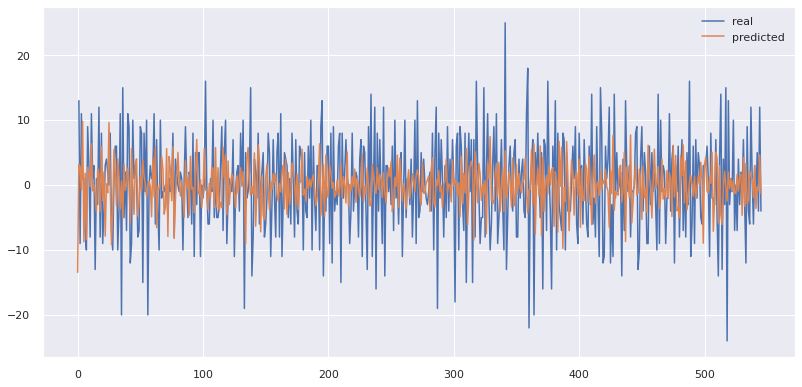

In [49]:
# predict for the evauation set and compare
prediction, conf_int = arma_model.predict(n_periods = X_eval_diff.shape[0], return_conf_int=True)

# let's quickly visualize the forecast
eval_df = pd.DataFrame(X_eval_diff.values, columns = ['real'])
eval_df['predicted'] = prediction
eval_df.plot()

**Check residuals**

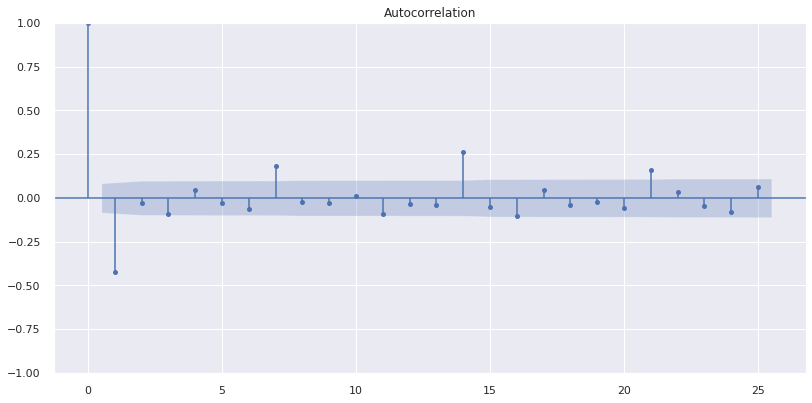

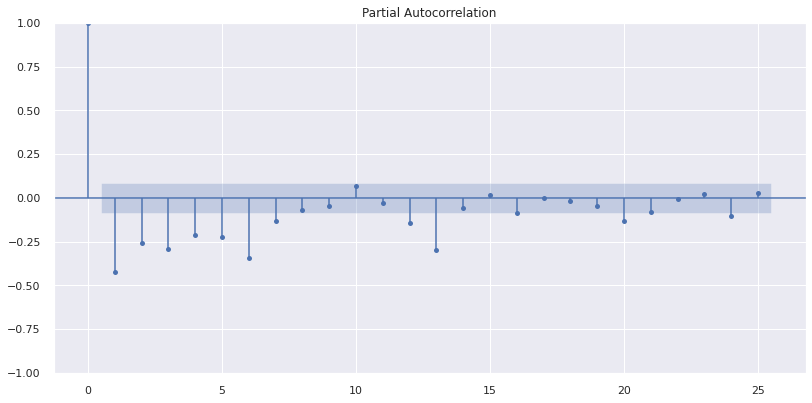

In [50]:
xresiduals = X_eval_diff.dropna() - prediction[1:]
plot_acf(xresiduals, lags = 25); print(); plot_pacf(xresiduals, lags = 25, method='ywm'); print();

There is still information left in the residuals.

In [51]:
arma_model_proper = arma_model.named_steps['arima']

In [52]:
y_true = X_eval_diff.dropna().values # first value is NA (because there was no previous value to compare it with)
preds = prediction[1:] # remove first value, so that real and predictd have the same length

mae_arma = mean_absolute_error(y_true, preds)

mae_arma

6.7946296089430005

In [53]:
new_result = pd.DataFrame.from_dict({'method':['FourierFeaturizer m=365'], 'mae':[mae_arma]})
new_result.index = ['ARMA']
results_df = results_df.append(new_result)
results_df

method       mae
Triple exponential smoothing                 additive  5.411132
ARMA                          FourierFeaturizer m=365  6.794630

This worked out worse than triple smoothing. I'll proceed to SARIMA, where I don't have to differentiate beforehand.   

# 4.2.2 SARIMA

S stands for seasonality
I stands for integrated (trend)

SARIMA model is a ARIMA(p,d,q)(P,D,Q)m, where:
- m = the number of periods in each season
- p,d,q = the usual ARIMA parameters
- P,D,Q = the autoregressive, differencing, and moving average terms for the seasonal part of the model.

For (p, d, q) I can use the values auto-detected earlier. Except that now d=1 (I will let autoarima perform differencing).

**Seasonality**  
For (P,D,Q), I'll check the autocorrelation plots of the seasonal component.

In [54]:
decomposition = sm.tsa.seasonal_decompose(X_train, period=365, model = 'additive') 

In [55]:
# check stationarity of the seasonal component
result = adfuller(decomposition.seasonal)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.601257
p-value: 0.092738


Seasonality is non-stationary (ADF test above).

In [56]:
seas_dff = decomposition.seasonal.diff().dropna()

# check stationarity
result = adfuller(seas_dff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.276481
p-value: 0.000000


Differencing it once makes it stationary (ADF test above), so `D`=1.

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,



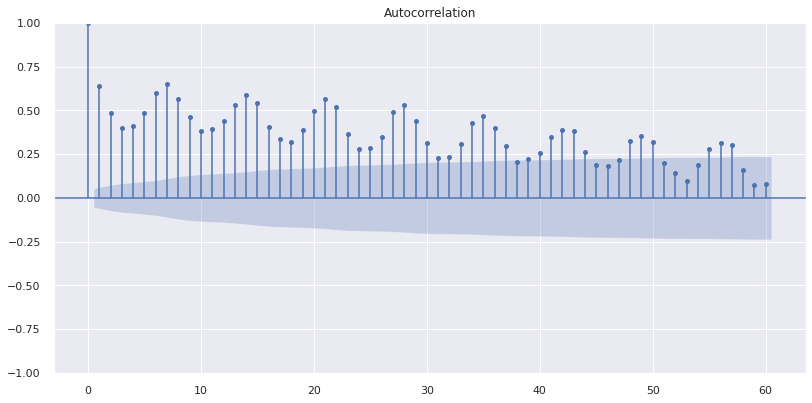

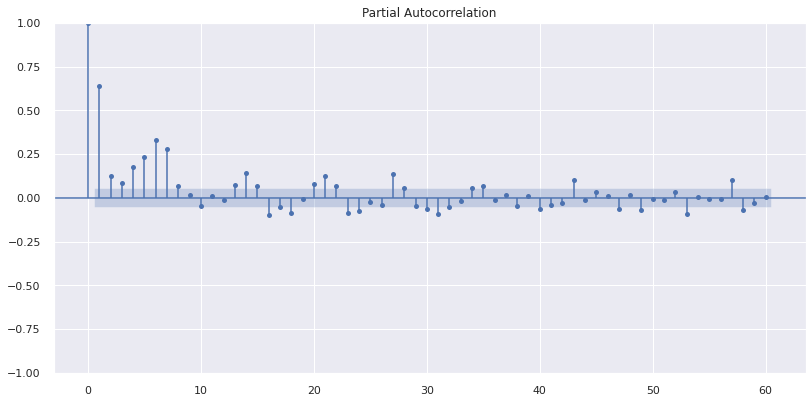

In [57]:
plot_acf(decomposition.seasonal, lags = 60); print(); plot_pacf(decomposition.seasonal, lags = 60); print()

In theory, the ACF should inform the `Q` and the PACF should inform the `P` value for the SARIMA, but it's difficult to tell in this case. I'll let autoarima decide. 

I will set m = 7 (consider seasonality of 7 days). I know I have two seasonalities: weekly and yearly, but SARIMA forced me to choose only one. 

In [58]:
start = time.time()

sarima_model = auto_arima(X_train, 
                             start_p = 7, max_p = 7,
                             start_q = 7, max_q = 10,
                             d=1,
                             m=7,
                             seasonal=True,
                             start_P=1, start_Q=1,
                             D=1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

end = time.time()
print(f'Took {(end - start)/60:.2f} minutes')

Performing stepwise search to minimize aic
 ARIMA(6,1,6)(1,1,1)[7]             : AIC=inf, Time=21.34 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=8970.184, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=8332.317, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=8650.413, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=8213.467, Time=0.80 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=3.79 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=8545.645, Time=0.62 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=8052.405, Time=1.10 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=8173.397, Time=0.52 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=4.27 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.72 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=7978.461, Time=1.44 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=8113.508, Time=0.72 

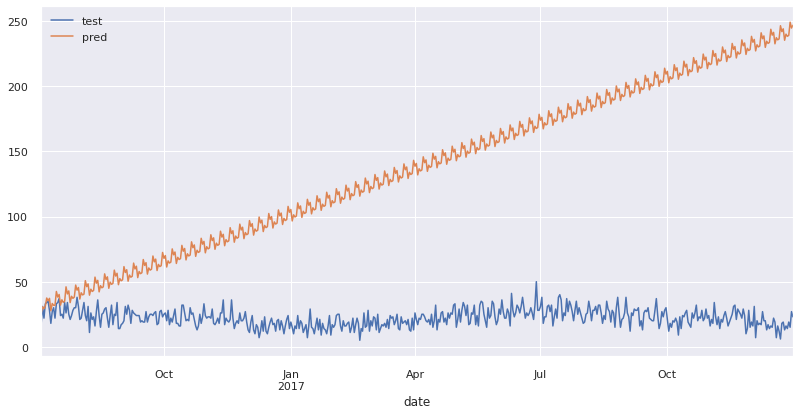

In [59]:
predicted, conf_int = sarima_model.predict(n_periods=len(X_eval), return_conf_int=True)

pd.DataFrame({'test':X_eval,'pred':predicted}).plot();plt.show()

In [60]:
mae_sarima = mean_absolute_error(X_eval.values, predicted)

mae_sarima

114.89037112093263

This has gone wrong, apparently. 

**Include yearly seasonality in the SARIMA model**

In [61]:
start = time.time()

sarima_model2 = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=365)),
    ("arima", auto_arima(X_train, 
                             start_p=7, start_q=5,
                             max_p=7, max_q=7, 
                             d=1,
                             m=7,
                             seasonal=True,
                             start_P=1, start_Q=1,
                             D=1,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True))
])

sarima_model2.fit(X_train)

predicted = sarima_model2.predict(n_periods=len(X_eval))

mae_sarima2 = mean_absolute_error(X_eval.values, predicted)

mae_sarima2

Performing stepwise search to minimize aic
 ARIMA(6,1,5)(1,1,1)[7]             : AIC=inf, Time=18.21 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=8970.184, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=8332.317, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=8650.413, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=8213.467, Time=0.89 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.29 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.88 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=8545.645, Time=0.55 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=8052.405, Time=0.95 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=8173.397, Time=0.52 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=4.49 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.78 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=7978.461, Time=1.46 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=8113.508, Time=0.61 

78.29033049945392

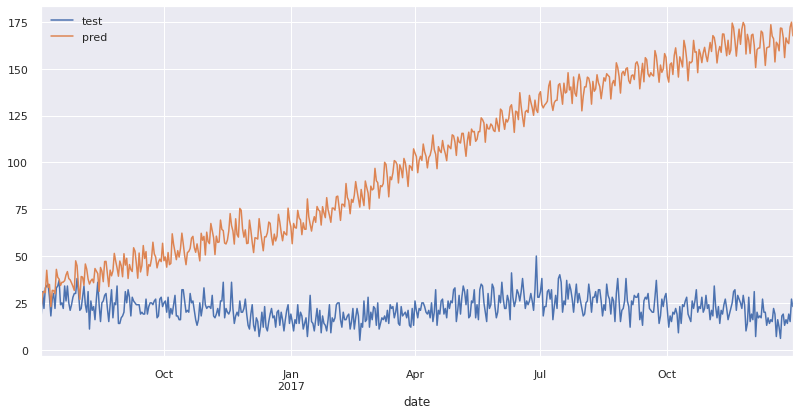

In [62]:
predicted = sarima_model2.predict(n_periods=len(X_eval))

pd.DataFrame({'test':X_eval,'pred':predicted}).plot();plt.show()

Still awful results. I conclude that ARMA & Co is a no-go for this data.

# 4.3 Prophet & Neural Prophet

# 4.3.1 Prophet

The next level, after the classical exponential smoothing methods is Prophet, developed by Facebook.  

Prophet is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

It works best with time series that have strong seasonal effects and several seasons of historical data. 

Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.  

One of its greatest avantages is that it cah handle multiple seasonaliy ocmponents (unlike exponential smoothing), which is something that as we saw earlier, we may need for this dataset.

A very good resource for getting started with Prophet is <a href='https://www.kaggle.com/konradb/ts-1a-smoothing-methods'>this notebook by Konrad Banakewicz</a> and its associated <a href='https://www.youtube.com/watch?v=kAI67Sz92-s&ab_channel=AbhishekThakur'>video lecture here</a>.  

Also, <a href='https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/'>this tutorial</a> by Jason Brownlee.

Preparing the dataset:  
Prophet expects input in a precise format:    
- it must consist of a date column named 'ds' (dataframe index or an actual column)   
- it must contain column 'y' (the actual values to be used for model fitting)

In [63]:
x_train = X_train.reset_index()[['date', 'sales']].rename(columns={"date": "ds", "sales": "y"})

Prophet can be configured through multiple parameters. If none are given, the model will try to infer the best values. Let's try this.  

The fitting function is very verbose. Later I will add code to supress this output.

Initial log joint probability = -30.6342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       2306.73   0.000765197       165.583   6.652e-06       0.001      153  LS failed, Hessian reset 
      99       2307.23   0.000473468       97.3659      0.3935           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       2307.73   0.000647842       129.283   5.867e-06       0.001      287  LS failed, Hessian reset 
     199       2308.22   1.42762e-05       93.4772      0.2982           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       2308.23   1.24152e-07       78.8279           1           1      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


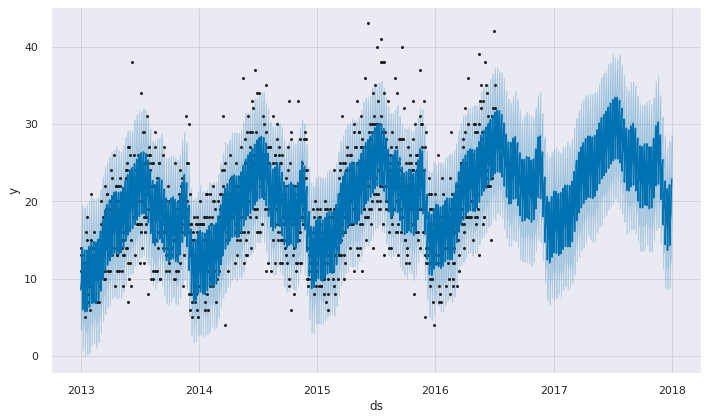

In [64]:
# intantiate a model with default parameters
m_add = Prophet() 

# fit the model
m_add.fit(x_train) 

# get a suitable dataframe that extends into the future a specified number of days
# forecast will contain the prediction for all x_train dates + the prediction for 
#`periods` number of days into the future
future = m_add.make_future_dataframe(periods=len(X_eval)) 

# in-sample predictions as well as out of sample predictions (if periods above was different than 0)
forecast_add = m_add.predict(future)

m_add.plot(forecast_add)

plt.show()

Some notes on the plot above:  
- the training data is represented as black dots  
- the forecast is a blue line with upper and lower bounds in a blue shaded area  

The predictions look modest. The actual data shows higher volatility than the model predicts. However, this is similar to what the triple exponential smoothing predicted.  

One aspect that can, in principle, be improved from the triple smoothing by using Prophet is modeling the weekly trend. Remember the residuals form the triple smoothing prediction were showign signs of a weekly dependency ? Because triple smoothing can only model one seasonality. Prophet however models several. To vizualize this feature, I'll use the `plot_components` method.

`Prophet.plot_components` method:  
- by default it will show the trend, yearly seasonality, and weekly seasonality of the time series. 
- if we included holidays, we would see those here, too.  

I didn't have to mention these explicitly. Prophet decided which seasonalities to look for based on the resolution of the dataset.  

If I had hourly data, there woul have been a daily seasonality shown in the following plot too.

Decorator to supress output (the very verbose table seen in the previous run of Prophet, above).

In [65]:
# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [66]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m_add, forecast_add)

plot_components_plotly(m_add, forecast_add)


WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.7/site-packages/plotly/io/_json.py:469: UserWarning:

Discarding nonzero nanoseconds in conversion




**Change points**  

An interesting functionality of Prophet is the estimation of change points. By default, it will try to estimate 25 of these. The number can be adjusted and the points can also be manually provided (useful when domain knolwdge allows for this).  

I want to see the change points estimation in action.

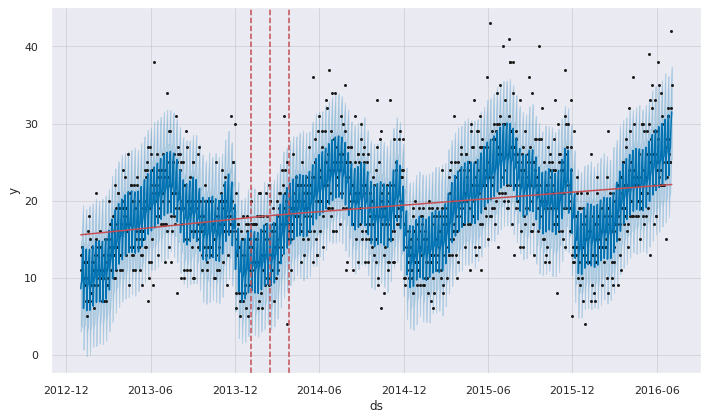

In [67]:
with suppress_stdout_stderr():

    # intantiate a model with default parameters
    m0 = Prophet() 

    # fit the model
    m0.fit(x_train) 

    future = m0.make_future_dataframe(periods=0) 

    forecast = m0.predict(future)

    fig = m0.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), m0, forecast)

    plt.show()

By default, Prophet tries to fit 25 changepoints using an algorithm that tries to push as many as them to 0 as possible. 

I'll try another method, that doesn't try to push changepoints to a minimum. 

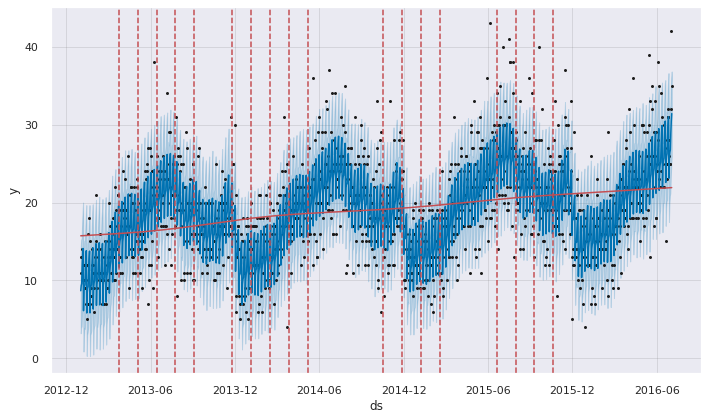

In [68]:
with suppress_stdout_stderr():

    # use the mcmc_samples functionality
    m1 = Prophet(mcmc_samples=300) 

    # fit the model
    m1.fit(x_train) 

    future = m1.make_future_dataframe(periods=0) 

    forecast = m1.predict(future)

    fig = m1.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), m1, forecast)

    plt.show()

 Examine the magnitude of the rate change at each changepoint, for the two approaches: without mcmc and with mcmc (Bayesian inference).

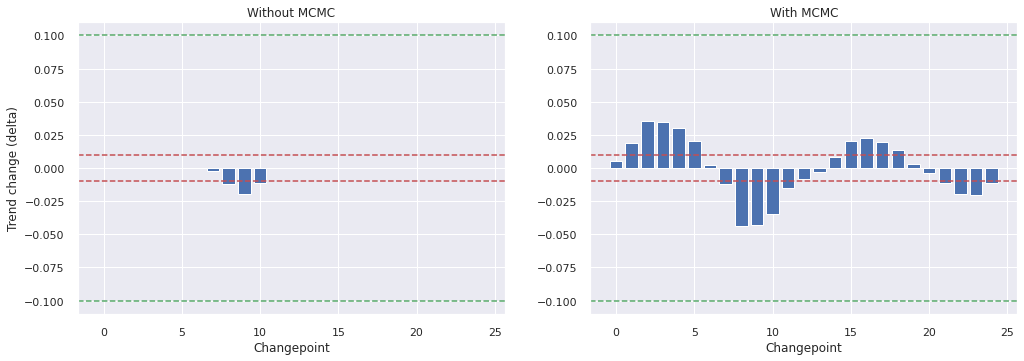

In [69]:
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121)
ax.bar(np.arange(25), np.nanmean(m0.params['delta'], axis=0))
ax.set_title('Without MCMC')
ax.set_xlabel('Changepoint')
ax.set_ylabel('Trend change (delta)')
ax.axhline(y=0.01, color='r', ls='--')
ax.axhline(y=-0.01, color='r', ls='--')
ax.axhline(y=0.1, color='g', ls='--')
ax.axhline(y=-0.1, color='g', ls='--')

ax = fig.add_subplot(122)
ax.bar(np.arange(25), np.nanmean(m1.params['delta'], axis=0))
ax.set_xlabel('Changepoint')
ax.axhline(y=0.01, color='r', ls='--')
ax.axhline(y=-0.01, color='r', ls='--')
ax.axhline(y=0.1, color='g', ls='--')
ax.axhline(y=-0.1, color='g', ls='--')
ax.set_title('With MCMC');

**Adjusting trend flexibility**

If the trend changes underfit (not enough flexibility), one can adjust the strength of the sparse prior using the input argument `changepoint_prior_scale`. By default, this parameter is set to 0.05. According to <a href='https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet'>Prophet documentation</a>, increasing it will make the trend more flexible:

mae: 4.071612795333414


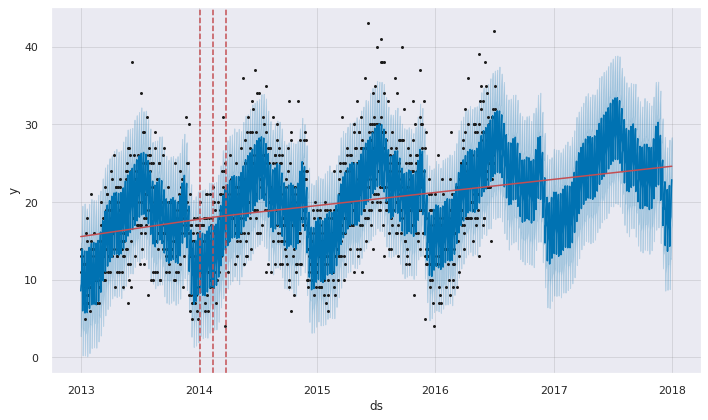

mae: 4.027245973090919


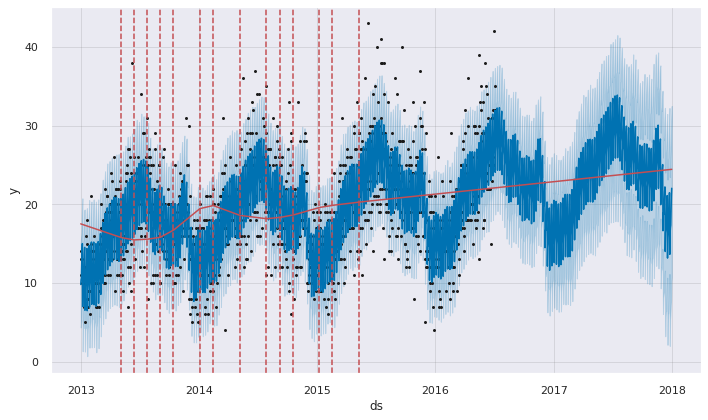

mae: 3.879429010603386


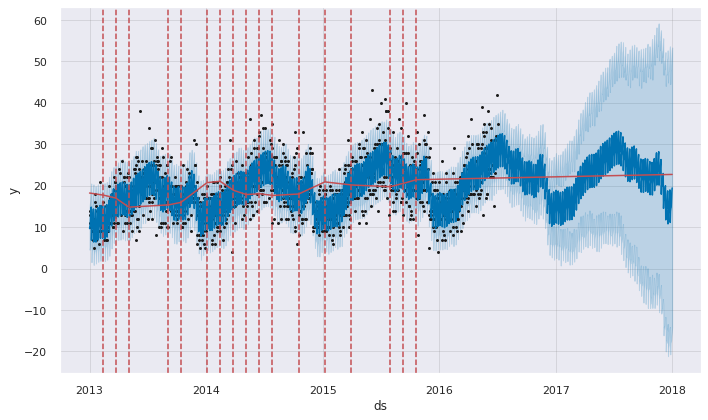

In [70]:
y_true = X_eval.values

for thresh in [0.05, 1, 5]:
    with suppress_stdout_stderr():

        # use the mcmc_samples functionality
        m1 = Prophet(changepoint_prior_scale=thresh) 

        # fit the model
        m1.fit(x_train) 

        future = m1.make_future_dataframe(periods=len(X_eval)) 

        forecast = m1.predict(future)

        y_pred = forecast[-len(X_eval):]['yhat'].values
        print(f'mae: {mean_absolute_error(y_true, y_pred)}')
        
        fig = m1.plot(forecast)
        a = add_changepoints_to_plot(fig.gca(), m1, forecast)

        plt.show()

**Multiplicative seasonality**

Initial log joint probability = -30.6342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2320.25    0.00192189       167.542           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       2320.39   1.14605e-07       71.4311      0.3614           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


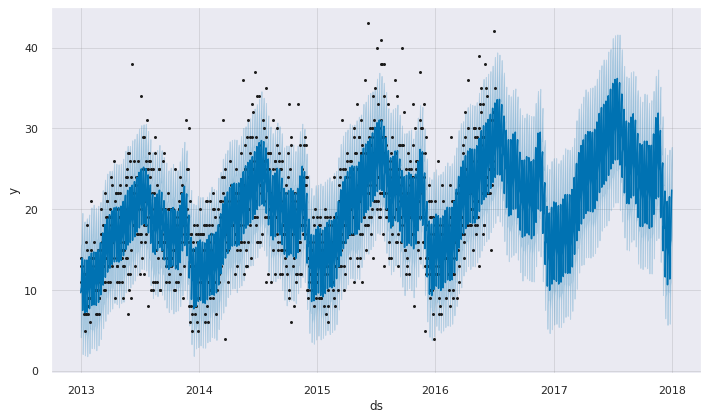

In [71]:
# intantiate a model with default parameters
m_mul = Prophet(seasonality_mode='multiplicative') 

# fit the model
m_mul.fit(x_train) 

# get a suitable dataframe that extends into the future a specified number of days
# forecast will contain the prediction for all x_train dates + the prediction for 
#`periods` number of days into the future
future = m_mul.make_future_dataframe(periods=len(X_eval)) 

# in-sample predictions as well as out of sample predictions (if periods above was different than 0)
forecast_mul = m_mul.predict(future)

m_add.plot(forecast_mul)

plt.show()

It's difficult to judge with the naked eye is there's a difference in results. I proceed with formal model evaluation.

**Model evaluation**

In [72]:
# calculate MAE between expected and predicted values for december
y_true = X_eval.values

y_pred = forecast_add[-len(X_eval):]['yhat'].values
mae_add = mean_absolute_error(y_true, y_pred)

y_pred = forecast_mul[-len(X_eval):]['yhat'].values
mae_mult = mean_absolute_error(y_true, y_pred)

new_result = pd.DataFrame.from_dict({'method':['additive', 'multiplicative'], 'mae': [mae_add, mae_mult]})
new_result.index = ['Prophet default', 'Prophet default']
results_df = results_df.append(new_result)
results_df

method       mae
Triple exponential smoothing                 additive  5.411132
ARMA                          FourierFeaturizer m=365  6.794630
Prophet default                              additive  4.071613
Prophet default                        multiplicative  4.082487

Visualize predictions versus real data (the held out evaluation set).

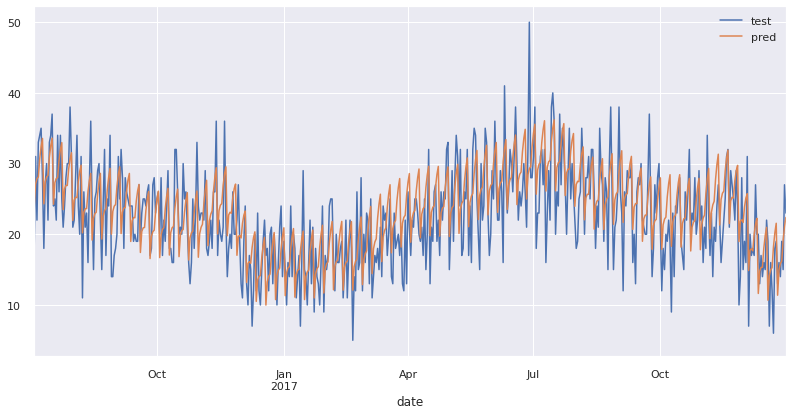

In [73]:
pd.DataFrame({'test':X_eval,'pred':y_pred}).plot();plt.show()

Additive seasonality for Prophet is marginally better.  

Prophet is better than triple smoothing.

The good thing about MAE is that it has the same unit of measurement as the initial data.  

Our dataset (sales) ranges between 0 and 40 (more or less). And we have a MAE of 4. That is, 10% of the amplitude of our 'signal'. This seems like it's not small.  

I'll try non-default parameter values for Prophet. First, let's see what parameters we can set for this model.

In [74]:
# uncomment the line below to see what parameters we can set for the Prophet instance
?Prophet

**Grid search for the best parameters**

- make some combinations of parameters to try in order to find the best model parameters  
- use cross-validation to obtain results for each parameters combination  

Parameters to try:

- *seasonality_prior_scale:*   
    Parameter modulating the strength of the
    seasonality model. Larger values allow the model to fit larger seasonal
    fluctuations, smaller values dampen the seasonality. Can be specified
    for individual seasonalities using add_seasonality
- *seasonality_mode:*   
    'additive' (default) or 'multiplicative'.  
    I did it 'by hand' earlier, but could have done it as part of the grid search here
- *changepoint_prior_scale:*   
    Parameter modulating the flexibility of the
    automatic changepoint selection. Large values will allow many
    changepoints, small values will allow few changepoints.  
    By default, Prophet will estimate 25 changepoints. 

<a href='https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation'>Prophet documentation</a> advises on which parameter should, may or should not be tuned.

In [75]:
# parameters that can potentially improve the performance of our model
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.5, 1.0, 5.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# check some of our combinations of parameters
all_params[:2]

[{'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'seasonality_mode': 'additive'},
 {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'seasonality_mode': 'multiplicative'}]

Read about how cross-validation is implemented in Prophet <a href='https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation'>here</a>. Short overview:  
- select cutoff points in the history; for each of them fit the model using data only up to that cutoff point  
- cross validation  can be done automatically for a range of historical cutoffs using the cross_validation function
- we specify the forecast horizon (`horizon`), and then optionally the size of the initial training period (`initial`) and the spacing between cutoff dates (`period`). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

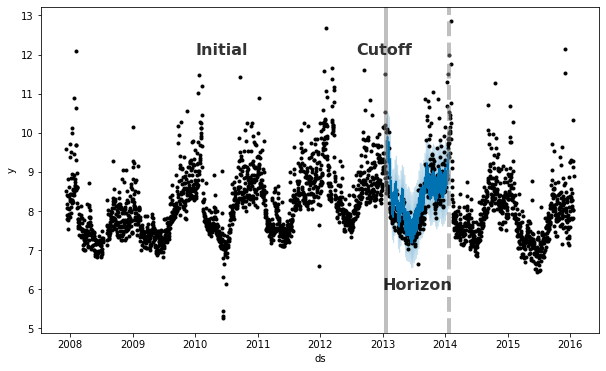
*image reproduced from <a href='https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation'>Prophet documentation</a>*

- start with initial training period of 2 years, so we have 2 times the amount of data take by the largest season (2 years) for training (2 x 366 days, to be sure)
- predict for one year (horizon = 365 days)

In [76]:
rmses = [] 
maes = []

with suppress_stdout_stderr():
    for params in all_params:
        m = Prophet(**params).fit(x_train);
        df_cv = cross_validation(m, initial = '732 days', period = '365 days', horizon=f'{len(X_eval)} days', parallel="processes")  
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])
        maes.append(df_p['mae'].values[0])

In [77]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes
tuning_results

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
5                     0.001                     1.00   multiplicative   
6                     0.001                    10.00         additive   
7                     0.001                    10.00   multiplicative   
8                     0.001                    20.00         additive   
9                     0.001                    20.00   multiplicative   
10                    0.050                     0.01         additive   
11                    0.050                     0.01   multiplicative   
12                    0.050                     0.10         additive   
13                    0.050                     0.10   multiplicative   
14                    0.050                     1.00         additive   
15                    0.050                     1.00   multiplicative   
16                    0.050                    10.00         additive   
17                    0.050                    10.00   multiplicative   
18                    0.050                    20.00         additive   
19                    0.050                    20.00   multiplicative   
20                    0.500                     0.01         additive   
21                    0.500                     0.01   multiplicative   
22                    0.500                     0.10         additive   
23                    0.500                     0.10   multiplicative   
24                    0.500                     1.00         additive   
25                    0.500                     1.00   multiplicative   
26                    0.500                    10.00         additive   
27                    0.500                    10.00   multiplicative   
28                    0.500                    20.00         additive   
29                    0.500                    20.00   multiplicative   
30                    1.000                     0.01         additive   
31                    1.000                     0.01   multiplicative   
32                    1.000                     0.10         additive   
33                    1.000                     0.10   multiplicative   
34                    1.000                     1.00         additive   
35                    1.000                     1.00   multiplicative   
36                    1.000                    10.00         additive   
37                    1.000                    10.00   multiplicative   
38                    1.000                    20.00         additive   
39                    1.000                    20.00   multiplicative   
40                    5.000                     0.01         additive   
41                    5.000                     0.01   multiplicative   
42                    5.000                     0.10         additive   
43                    5.000                     0.10   multiplicative   
44                    5.000                     1.00         additive   
45                    5.000                     1.00   multiplicative   
46                    5.000                    10.00         additive   
47                    5.000                    10.00   multiplicative   
48                    5.000                    20.00         additive   
49                    5.000                    20.00   multiplicative   

         rmse        mae  
0    5.115057   4.015919  
1    6.225667   5.037067  
2    4.715491   3.700596  
3    4.750276   3.752678  
4    4.695517   3.657008  
5    4.801253   3.815659  
6    4.702555   3.676506  
7    4.869420   3.872075  
8    4.700326   3.672040  
9    5.120

In [78]:
# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)

best_params = all_params[np.argmin(maes)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}
{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}


In [79]:
new_result = pd.DataFrame.from_dict({'method':[best_params['seasonality_mode']], 'mae': [min(maes)]})
new_result.index = ['Prophet grid search']
results_df = results_df.append(new_result)
results_df

method       mae
Triple exponential smoothing                 additive  5.411132
ARMA                          FourierFeaturizer m=365  6.794630
Prophet default                              additive  4.071613
Prophet default                        multiplicative  4.082487
Prophet grid search                          additive  3.657008

Even after finding the best parameters, the results (mae) did not improve that much.  

I'll have a closer look at predictions to try to see what could be improved.

In [80]:
#temporary trick
#best_params = {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'growth': 'linear'}
#best_m = Prophet(**best_params).fit(x_train)

In [81]:
# retrain with the best parameters
best_m = Prophet(**best_params).fit(x_train);
future = best_m.make_future_dataframe(periods=0) 
best_forecast = best_m.predict(future)

# examine a short portion of the data
xfor = best_forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']][-60:]
xfor.head(10)

Initial log joint probability = -30.6342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2292.72   2.52775e-07       5109.06        0.52        0.52      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       2293.89   9.57513e-05       5092.59   2.061e-08       0.001      185  LS failed, Hessian reset 
     180       2294.87   1.60642e-05       5066.48   3.458e-09       0.001      296  LS failed, Hessian reset 
     199       2294.96   8.60935e-08       4711.83      0.2298      0.2298      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       2294.97   4.83263e-09       5140.03      0.3033      0.3033      340   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


ds       yhat  yhat_upper  yhat_lower
1220 2016-05-05  22.975535   28.003254   17.874894
1221 2016-05-06  25.245827   30.540873   20.320399
1222 2016-05-07  26.839703   31.877229   21.411857
1223 2016-05-08  27.900193   33.382101   22.730909
1224 2016-05-09  19.664837   24.400250   14.515154
1225 2016-05-10  22.493403   27.284549   16.980021
1226 2016-05-11  23.251089   28.456150   18.009613
1227 2016-05-12  23.592565   28.817875   18.443165
1228 2016-05-13  25.929601   31.398132   20.287237
1229 2016-05-14  27.584161   32.702749   22.424802

In [82]:
# combine the forecast dataframe with the original test data
xfor = pd.merge(left = xfor, right = x_train, on = 'ds', how = 'left')

<AxesSubplot:>

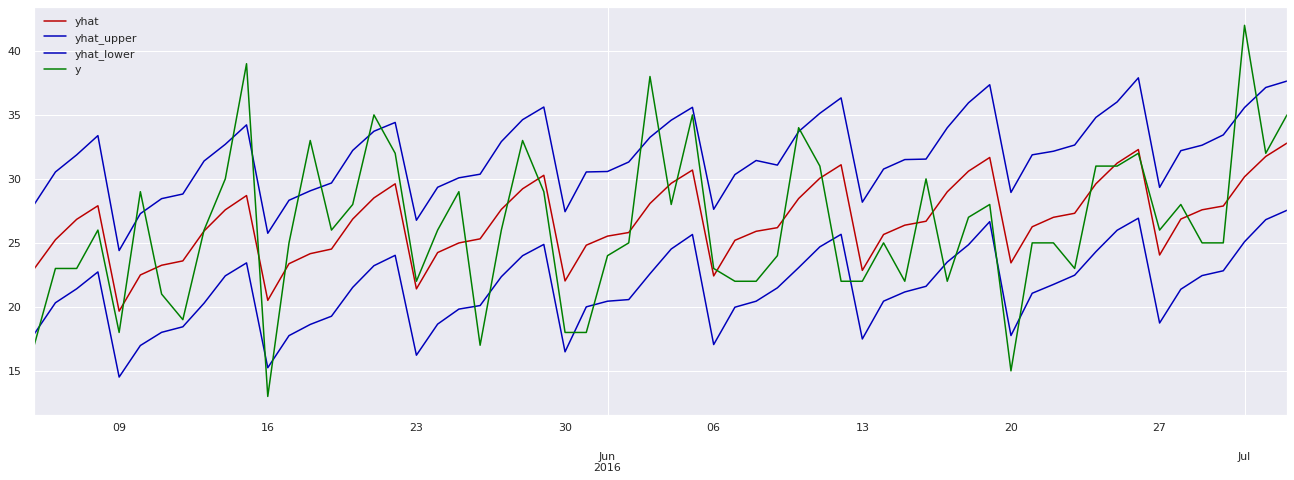

In [83]:
colors = ['#BB0000' , '#0000BB', '#0000BB', 'green']

xfor['ds'] = pd.to_datetime(xfor['ds'])
xfor.set_index('ds').plot(color = colors, figsize=(20, 7), xlabel = '')

Observations:  
- the model understates the magnitude of fluctuations in the data
- confidence intervals are wide (a width of 10 for a data that oscillates mainly between 10 and 50 seems quite broad).

# 4.3.2 Neural Prophet

<a href='https://neuralprophet.com/html/index.html'>Neural Prophet documentation</a>

In case we skipped Prophet section and are jumping straight to Neural Prophet, the input dataset needs to have particular names for columns.

In [84]:
x_train = X_train.reset_index()[['date', 'sales']].rename(columns={"date": "ds", "sales": "y"})

In [85]:
pd.options.mode.chained_assignment = None

# otherwise Neural Prophet is too verbose
neuralprophet.utils.set_log_level(log_level='WARNING')

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

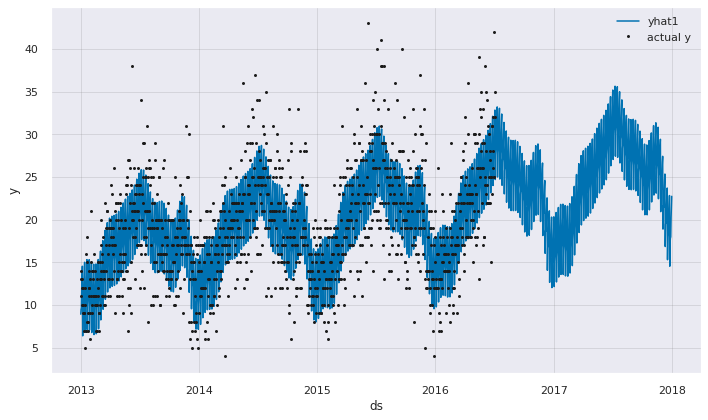

In [86]:
m_neural = NeuralProphet()

metrics = m_neural.fit(x_train, freq="D");

# predict one year into the future 
future = m_neural.make_future_dataframe(df=x_train, periods=len(X_eval), n_historic_predictions = True) # by default, historical predictions are turned off in Neural Prophet

# in-sample predictions as well as out of sample predictions (if periods above was different than 0)
forecast_neural = m_neural.predict(df=future)

fig_forecast = m_neural.plot(forecast_neural)

Check individual components, same as done earlier with Prophet.

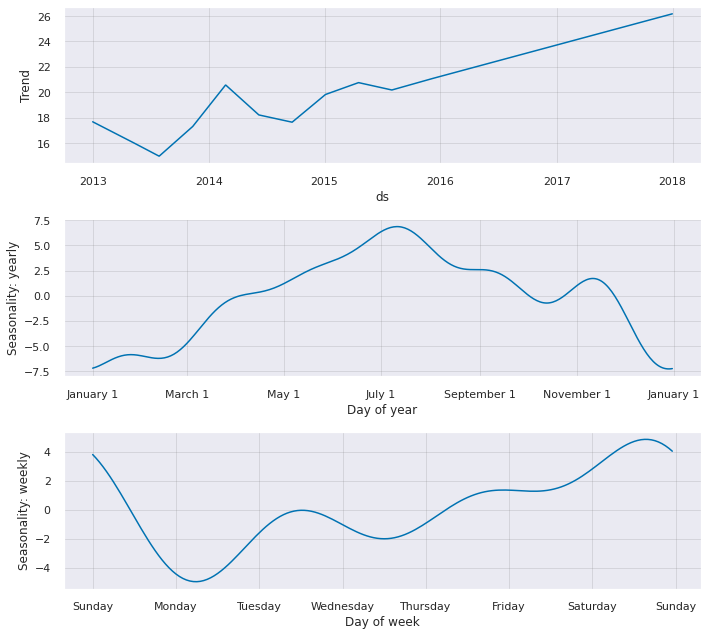

In [87]:
fig_components = m_neural.plot_components(forecast_neural)

For comparison, let's revisit the components of the regular Prophet model.

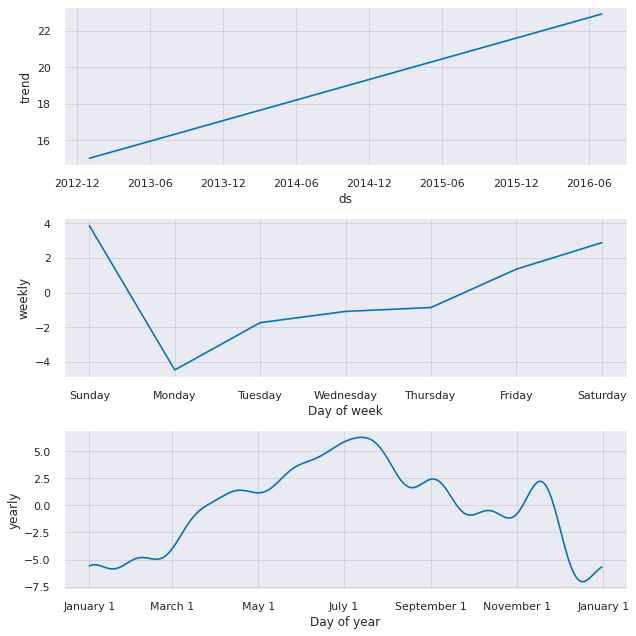

In [88]:
fig_components = best_m.plot_components(best_forecast)

**Neural Prophet vs Prophet**

Observations from the plot above:
- the trend has more inflection points than the regular Prophet  
- the weekly curve is less rigid (more curvy)

In [89]:
y_true = X_eval.values # just to make sure we didn't accidentally change it

That was Neural Prophet with default parameters. Can we get better ?  

What parameters can be set in Neural Prophet:

In [90]:
#NeuralProphet?

**Cross-validation** in Neural Prophet  

It's slightly different than for regular Prophet.  

I compute MAE result from 5-fold cross-validation so that the metric is estimated through a similar process as for the regular Prophet (same same, but different actually).

n_lags=7 means that I'm using the autoregression component of Neural Prophet, regressing the series on itself with a lag of 7 steps back.  

Sadly, Neural Prophet does not provide a mechanism for grid searching the best parameters. So I'm gonna do it manually.  

For grid search I chose these parameters:  
trend config parameters:  
-  `trend_reg` (float): Parameter modulating the flexibility of the automatic changepoint selection.
        Large values (~1-100) will limit the variability of changepoints.
        Small values (~0.001-1.0) will allow changepoints to change faster.
        default: 0 will fully fit a trend to each segment.  

seasonality config parameter:  
- `seasonality_mode` (str): 'additive' (default) or 'multiplicative'.  
- `seasonality_reg` (float): Parameter modulating the strength of the seasonality model.
        Smaller values (~0.1-1) allow the model to fit larger seasonal fluctuations,
        larger values (~1-100) dampen the seasonality.
        default: None, no regularization

auto-regression config parameters:
- `n_lags` (int): Previous time series steps to include in auto-regression. Aka AR-order
- `ar_sparsity` (float): [0-1], how much sparsity to enduce in the AR-coefficients.
        Should be around (# nonzero components) / (AR order), eg. 3/100 = 0.03
        
model config params:
- `num_hidden_layers` (int): number of hidden layer to include in AR-Net. defaults to 0.
- `d_hidden` (int): dimension of hidden layers of the AR-Net. Ignored if num_hidden_layers == 0.      


train config params:
- `learning_rate` (float): Maximum learning rate setting for 1cycle policy scheduler.
        default: None: Automatically sets the learning_rate based on a learning rate range test.
        For manual values, try values ~0.001-10.
- `epochs` (int): Number of epochs (complete iterations over dataset) to train model.
        default: None: Automatically sets the number of epochs based on dataset size.
        For best results also leave batch_size to None.
        For manual values, try ~5-500.
- `batch_size` (int): Number of samples per mini-batch.
        default: None: Automatically sets the batch_size based on dataset size.
        For best results also leave epochs to None.
        For manual values, try ~1-512.
        
If using AR, <a href='https://neuralprophet.com/html/autoregression_yosemite_temps.html'>the documentation</a>, recommends to experiment with differnt: learning_rate, epochs and batch_size, in this order. Because presumably a model that includes AR is a bit more difficult to fit. The automatic selection of hyperparameters may not lead to ideal results. The automatically set hyperparameters (printed out as ‘INFO’ level logs) can serve as a good starting point. If you want to see those values, run a model fit without setting these params and change the log level back to INFO (I set it to WARNING earlier because Prophet is too verbose for me).

In [91]:
# subset of params chosen after running the first 
param_grid_subset = {  
    'trend_reg': [0, 0.1, 1, 3],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True], 'weekly_seasonality': [True],
    'seasonality_reg': [0, 0.1, 1, 3],
    'n_lags': [14, 28],
    'num_hidden_layers': [3],
    'd_hidden': [16],
    "epochs": [300],
    "batch_size": [32],
    'learning_rate': [0.1, 1]
}

out_file = 'neural_grid.csv'

The grid search function that we can cal later with different combinations of parameters.  
I am saving output to a csv file.  
When running in Kaggle, go for 'Run and save all', because it will take several hours and this way you'll let the notebook run in the background and have the output ready in the 'Data' tab even when the kernel shuts down due to idleness.

In [92]:
def cv_grid_search(param_grid, out_file): 
    with open(out_file, 'w', newline='') as outcsv:
        writer = csv.writer(outcsv)

        header = list(param_grid.keys())
        header.append('avg mae')

        writer.writerow(header)

    # generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    print(f'Fitting {len(all_params)} models')

    METRICS = ['RMSE', 'MAE']
    neural_rmses = [] 
    neural_maes = []

    #for params in tqdm(all_params):
    for params in all_params:
        start = time.time()

        set_random_seed(0)
        folds = NeuralProphet(**params).crossvalidation_split_df(x_train, freq="D", k=5, fold_pct=0.20, fold_overlap_pct=0.5)

        metrics_train = pd.DataFrame(columns=METRICS)
        metrics_test = pd.DataFrame(columns=METRICS)

        for df_train, df_test in folds:
            m = NeuralProphet(**params)
            train = m.fit(df=df_train, freq="D")
            test = m.test(df=df_test)
            metrics_train = metrics_train.append(train[METRICS].iloc[-1])
            metrics_test = metrics_test.append(test[METRICS].iloc[-1])

        neural_rmses.append(metrics_test.RMSE.mean())
        neural_maes.append(metrics_test.MAE.mean())

        print(f'avg test mae: {metrics_test.MAE.mean()} for params: {params}')

        with open(out_file, 'a', newline='') as outcsv:
            writer = csv.writer(outcsv)

            row = list(params.values())
            row.append(metrics_test.MAE.mean())

            writer.writerow(row)

        end = time.time()
        print(f'Took {(end - start)/60:.2f} minutes')

Grid search takes long, because we're fiting 200 models.  
I ran it and saved the training results in `neural_grid_subset.csv`.

In [93]:
#cv_grid_search(param_grid_subset, out_file)

In [94]:
# parameters that can potentially improve the performance of our model
param_grid = {  
    'trend_reg': [0, 0.1, 1, 3],
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True], 'weekly_seasonality': [True],
    'seasonality_reg': [0, 0.1, 1, 3],
    'n_lags': [7, 14],
    'num_hidden_layers': [3, 4],
    'd_hidden': [16],
    "epochs": [200],
    "batch_size": [32, 64, 128],
    'learning_rate': [0.003, 0.01, 0.1]
}

out_file = 'neural_grid.csv' 

# cv_grid_search(param_grid, out_file)

**How to select the best parameters ?**  

Initially I thought of just checking the minimum MAE from he grid search above, which used cross-validation to minimize the chances that the result is a fluke.

In [95]:
logs_folder = "../input/neural-grid-subset/"

df = pd.read_csv(os.path.join(logs_folder, 'neural_grid_subset.csv'))

df.head()

trend_reg seasonality_mode  yearly_seasonality  weekly_seasonality  \
0        0.0         additive                True                True   
1        0.0         additive                True                True   
2        0.0         additive                True                True   
3        0.0         additive                True                True   
4        0.0         additive                True                True   

   seasonality_reg  n_lags  num_hidden_layers  d_hidden  epochs  batch_size  \
0              0.0      14                  3        16     300          32   
1              0.0      14                  3        16     300          32   
2              0.0      28                  3        16     300          32   
3              0.0      28                  3        16     300          32   
4              0.1      14                  3        16     300          32   

   learning_rate   avg mae  
0            0.1  4.881968  
1            1.0  4.580837  
2            0.1  4.680887  
3            1.0  4.637871  
4            0.1  4.933860

In [96]:
df[df['avg mae'] == df['avg mae'].min()]

trend_reg seasonality_mode  yearly_seasonality  weekly_seasonality  \
119        3.0   multiplicative                True                True   

     seasonality_reg  n_lags  num_hidden_layers  d_hidden  epochs  batch_size  \
119              0.1      28                  3        16     300          32   

     learning_rate   avg mae  
119            1.0  3.701884

But if you look closely at MAEs below 4, the settins tend to vary. So I felt like this can still be a fluke. So maybe a more sound approach is to use feature selection methods to find the most relevant features for the prediction of the outcome. 

**CART Regression Feature Importance**

**One-hot encode first**

First, I have to encode the categorical variable in the dataset, to be able to build regression models from this data. 

In [97]:
dummies_df = pd.get_dummies(df.seasonality_mode, prefix='season') # one hot encode 
df = df.join(dummies_df) # join the one-ho encoded columns with the initial dataset

In [98]:
predictors = list(df.columns) # independent variables
predictors.remove('avg mae')  # the dependent variable
predictors.remove('seasonality_mode')

X = df[predictors]
y = df['avg mae']

Feature: 0, Score: 0.57431
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.05068
Feature: 4, Score: 0.05534
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.05743
Feature: 10, Score: 0.26223
Feature: 11, Score: 0.00000


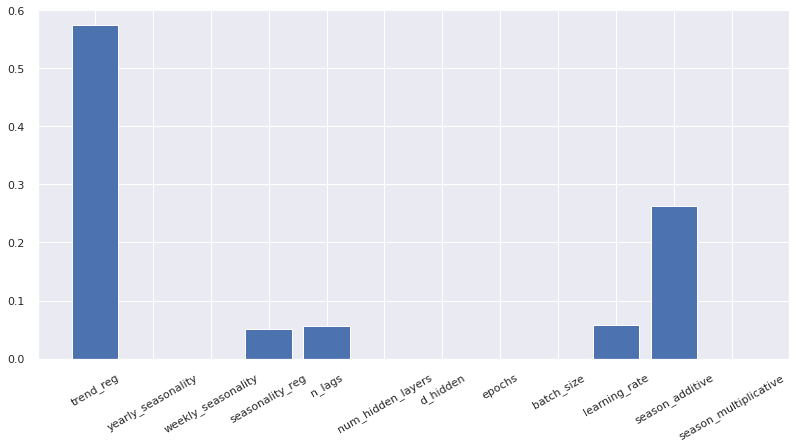

In [99]:
model = DecisionTreeRegressor()

# fit the model
model.fit(X, y)

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([X.columns[i] for i in range(len(importance))], importance)
plt.xticks(rotation=30)
plt.show()

From this, I get that seasonality should be additive (rather than multiplicative) and that `trend_reg` is the most important feature that determines the MAE of the model on the test set.  

Have a closer look at `trend_reg`

Text(0.5, 0.98, 'MAE by trend_reg')

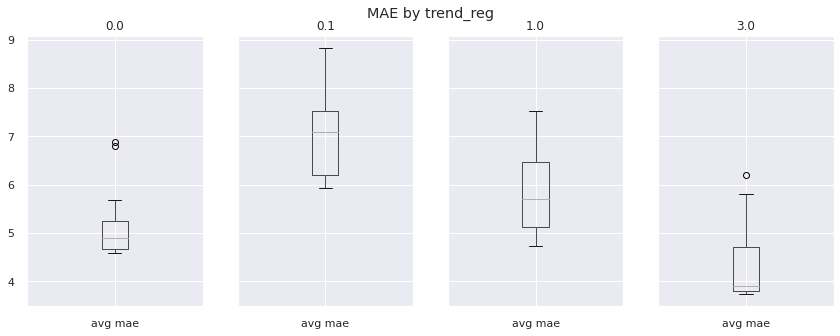

In [100]:
temp_df = df[df['season_additive'] == 1]

axes = temp_df.groupby('trend_reg').boxplot(column='avg mae', figsize=(14,5), layout = (1, 4))
fig = axes.iloc[0].get_figure()
fig.suptitle('MAE by trend_reg')

I'll keep the 3 and also try bigger `trend_reg` in further grid search.

Text(0.5, 0.98, 'MAE by n_lags')

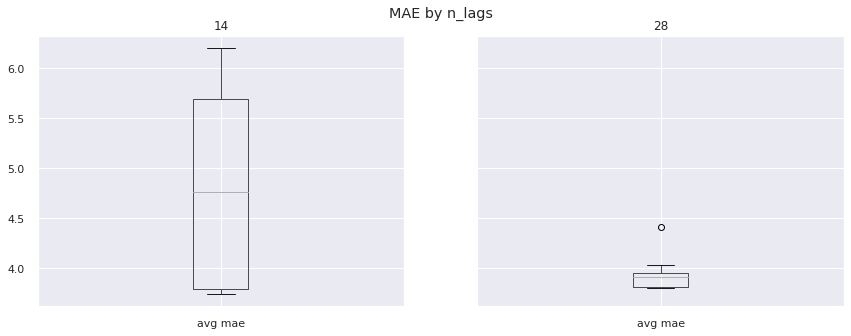

In [101]:
temp_df = df[(df['season_additive'] == 1) & (df['trend_reg'] == 3)]

axes = temp_df.groupby('n_lags').boxplot(column='avg mae', figsize=(14,5), layout = (1, 2))
fig = axes.iloc[0].get_figure()
fig.suptitle('MAE by n_lags')

I'll keep the 28 and also try bigger `n_lags` in further grid search.

Text(0.5, 0.98, 'MAE by seasonality_reg')

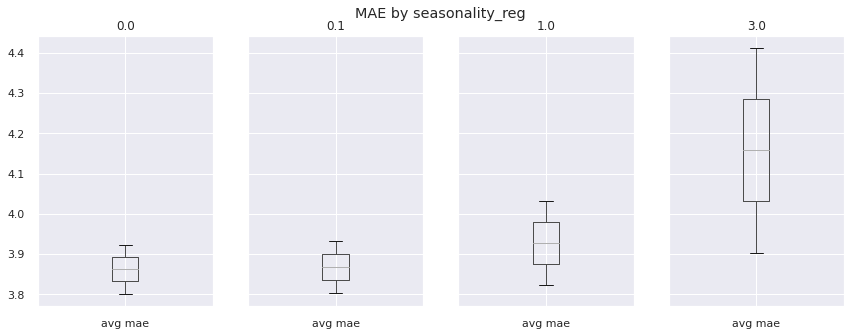

In [102]:
temp_df = df[(df['season_additive'] == 1) & (df['trend_reg'] == 3) & (df['n_lags'] == 28)]

axes = temp_df.groupby('seasonality_reg').boxplot(column='avg mae', figsize=(14,5), layout = (1, 4))
fig = axes.iloc[0].get_figure()
fig.suptitle('MAE by seasonality_reg')

I'll leave the default value of 0 for `seasonality_reg`

Text(0.5, 0.98, 'MAE by learning_rate')

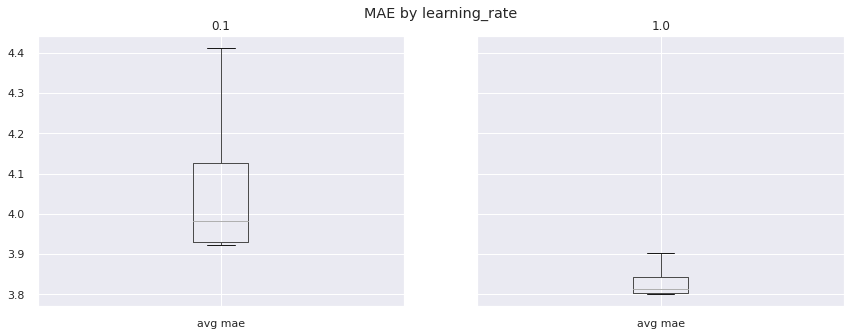

In [103]:
temp_df = df[(df['season_additive'] == 1) & (df['trend_reg'] == 3) & (df['n_lags'] == 28)]

axes = temp_df.groupby('learning_rate').boxplot(column='avg mae', figsize=(14,5), layout = (1, 2))
fig = axes.iloc[0].get_figure()
fig.suptitle('MAE by learning_rate')

**Overspecifying the AR network**

By setting `num_hidden_layers` and `d_hidden`, it's possible to overspecify the AR network (have way more parameters than the nubmer of trianing points). 

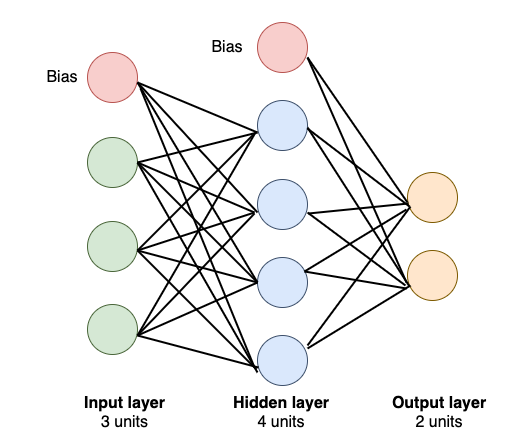

Simple exercise:  
`n_lags` = 28   
`num_hidden_layers` = 1    
`d_hidden` = 16  

Number of parameters between the input and the first layer: 28 * 16  
Between layer 2 and layer 3: 16 * 16  
etc.  

Total params: 28 (regressing of last 28 data points) x 16 x 1 (predicting one step ahead) = 448  
Same setup except for having 3 hidden layers: 114.688 network parameters to learn  
Size of training set: waay less than that



In [104]:
# parameters that can potentially improve the performance of our model
param_grid = {  
    'trend_reg': [3, 10],
    'seasonality_mode': ['additive'],
    'yearly_seasonality': [True], 'weekly_seasonality': [True],
    'seasonality_reg': [0],
    'n_lags': [28, 60],
    'num_hidden_layers': [0, 1, 3],
    'd_hidden': [8, 16],
    "epochs": [300],
    "batch_size": [32],
    'learning_rate': [1]
}

out_file = 'neural_grid_2nd.csv' 

# cv_grid_search(param_grid, out_file)

This doesn't take that long, because it's only 24 models this time. But I already ran it and uploaded the restults here. So I'll skip the 2nd grid search too and read from the csv file. 

In [105]:
#cv_grid_search(param_grid, out_file)

In [106]:
logs_folder = "../input/neural-grid-2nd/"

df = pd.read_csv(os.path.join(logs_folder, 'neural_grid_2nd.csv'))

df.head()

trend_reg seasonality_mode  yearly_seasonality  weekly_seasonality  \
0          3         additive                True                True   
1          3         additive                True                True   
2          3         additive                True                True   
3          3         additive                True                True   
4          3         additive                True                True   

   seasonality_reg  n_lags  num_hidden_layers  d_hidden  epochs  batch_size  \
0                0      28                  0         8     300          32   
1                0      28                  0        16     300          32   
2                0      28                  1         8     300          32   
3                0      28                  1        16     300          32   
4                0      28                  3         8     300          32   

   learning_rate   avg mae  
0              1  4.266087  
1              1  4.266087  
2              1  3.800761  
3              1  3.801365  
4              1  3.794093

In [107]:
df[df['avg mae'] == (df['avg mae'].min())]

trend_reg seasonality_mode  yearly_seasonality  weekly_seasonality  \
20         10         additive                True                True   

    seasonality_reg  n_lags  num_hidden_layers  d_hidden  epochs  batch_size  \
20                0      60                  1         8     300          32   

    learning_rate   avg mae  
20              1  3.718925

In [108]:
new_result = pd.DataFrame.from_dict({'method':['-'], 'mae': [df['avg mae'].min()]})
new_result.index = ['Neural Prophet grid search']
results_df = results_df.append(new_result)
results_df

method       mae
Triple exponential smoothing                 additive  5.411132
ARMA                          FourierFeaturizer m=365  6.794630
Prophet default                              additive  4.071613
Prophet default                        multiplicative  4.082487
Prophet grid search                          additive  3.657008
Neural Prophet grid search                          -  3.718925

Bummer ! Despite all efforts, I can't get any noticeable improvement from using Neural Prophet instead of Prophet.